# Desafío Data Scientist - LATAM Airlines

## 0. Introducción

___
Como parte del desafío LATAM se presenta una serie de problemas a responder a lo largo de este notebook en python 3. Para lo cual, se ha provisto de un archivo CSV con el dataset a usar y archivos vinculados a la solución (url: https://github.com/Mishagk/LATAM-Desafio-DS). 
<br><br>
Con todo esto, la principal problematica a responder o desarrollar es: *"predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL)"*


___

El desarrollo se hará en notebook de python formato `".ipynb"`. Se considerará el uso de un ambiente virtual en Anaconda, Visual Studio Code para el desarrollo y el versionamiento con github. 
<br><br>
Respecto al versionamiento en github, todo el desarrollo se realizará en la rama `"development"` y al finalizar se realizará una integración a la rama `"main"`. 
<br><br>
**Nota**: La rama de desarrollo `"development"` no se borrará con el fin de que se pueda evidenciar el historial de todos los cambios realizados.

## 1. Librerias

Previo a ejecutar este notebook se creará un entorno virtual en Anaconda (env name: latam1) en python **`3.9.13`**

Esto se puede lograr en la terminal de Anaconda Prompt, colocando: `conda create -n latam1 python=3.9.13`

In [350]:
# Version de python en entorno virtual de Anaconda
!python --version

Python 3.9.13


NOTA: Es importante que se ejecute el código con la versión de python indicada ya que las librerias dependen del mismo

Se procede a instalar las principales librerias a utilizar

In [354]:
# Instalar principales librerias (NOTA: Algunas librerias tienen versiones especificas)

!pip install scikit-learn==1.1.3
!pip install numpy==1.23.4
!pip install pandas
!pip install scipy
!pip install seaborn

Con las librerias instaladas, se realiza la importación de las mismas

In [366]:
# Importar librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sys
from matplotlib.ticker import PercentFormatter
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")  # Ignorar las advertencias, pero SI muestra los errores

## 2. Carga de Datos

In [299]:
# Leer datos desde la URL de github

# URL a github
url_github = "https://raw.githubusercontent.com/Mishagk/LATAM-Desafio-DS/master/dataset_SCL.csv"

# leer datos
data = pd.read_csv(url_github,sep=',',quotechar='"')

# ver primeras 5 filas
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1.0,1.0,2017.0,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2.0,1.0,2017.0,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3.0,1.0,2017.0,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4.0,1.0,2017.0,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5.0,1.0,2017.0,Jueves,I,American Airlines,Santiago,Miami


In [300]:
# informacion general de tabla

print('Cantidad columnas :',data.shape[1])
print('Cantidad registros:',data.shape[0])

Cantidad columnas : 18
Cantidad registros: 68206


___
El dataset leido contiene registro de los vuelos de aviones que aterrizaron o despegaron en Santiago de Chile (SCL). La descripción de cada variable:
<ul>
<li> Fecha-I : Fecha y hora programada del vuelo. (ordinal) </li>
<li> Vlo-I : Número de vuelo programado. (ordinal) </li>
<li> Ori-I : Código de ciudad de origen programado. (nominal) </li>
<li> Des-I : Código de ciudad de destino programado. (nominal) </li>
<li> Emp-I : Código aerolínea de vuelo programado. (nominal) </li>
<li> Fecha-O : Fecha y hora de operación del vuelo. (ordinal) </li>
<li> Vlo-O: Número de vuelo de operación del vuelo. (nominal) </li>
<li> Ori-O : Código de ciudad de origen de operación. (nominal) </li>
<li> Des-O : Código de ciudad de destino de operación. (nominal) </li>
<li> Emp-O : Código aerolínea de vuelo operado. (nominal) </li>
<li> DIA : Día del mes de operación del vuelo. (ordinal) </li>
<li> MES : Número de mes de operación del vuelo. (ordinal) </li>
<li> AÑO : Año de operación del vuelo. (ordinal) </li>
<li> DIANOM : Día de la semana de operación del vuelo. (ordinal) </li>
<li> TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional. (nominal) </li>
<li> OPERA : Nombre de aerolínea que opera. (nominal) </li>
<li> SIGLAORI : Nombre ciudad origen. (nominal) </li>
<li> SIGLADES : Nombre ciudad destino. (nominal) </li>
</ul>

Es importante considerar que al lado derecho de cada una se colocó si se puede considerar del tipo **`ordinal`** o **`nominal`**. Esto significa que en caso de ser ordinal, poseen un orden entre los valores, por ejemplo los dias, el orden: es `lunes`, `martes`, `miercoles`, `jueves`, etc. Por el otro lado, variables nominales como aerolinea no poseen un orden natural, no se puede decir por ejemplo que `LAN` es mayor de `TAM` o `SUK` de forma natural.

___

## 3. Preparación y exploración de datos

### 3.1. Calidad de datos

En esta sección revisaremos el estado de los datos en su condición de origen.

In [301]:
# Ver todas las columnas disponibles, la cantidad de datos nulos y el tipo de datos según se haya leido
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Fecha-I    68206 non-null  object 
 1   Vlo-I      68167 non-null  object 
 2   Ori-I      68167 non-null  object 
 3   Des-I      68167 non-null  object 
 4   Emp-I      68167 non-null  object 
 5   Fecha-O    68167 non-null  object 
 6   Vlo-O      68166 non-null  object 
 7   Ori-O      68167 non-null  object 
 8   Des-O      68167 non-null  object 
 9   Emp-O      68167 non-null  object 
 10  DIA        68167 non-null  float64
 11  MES        68167 non-null  float64
 12  AÑO        68167 non-null  float64
 13  DIANOM     68167 non-null  object 
 14  TIPOVUELO  68167 non-null  object 
 15  OPERA      68167 non-null  object 
 16  SIGLAORI   68167 non-null  object 
 17  SIGLADES   68167 non-null  object 
dtypes: float64(3), object(15)
memory usage: 9.4+ MB


In [302]:
# Ver cuantos datos "vacios" o "nulos" se tienen desde informacion origen (data raw)
data.isnull().sum()

Fecha-I       0
Vlo-I        39
Ori-I        39
Des-I        39
Emp-I        39
Fecha-O      39
Vlo-O        40
Ori-O        39
Des-O        39
Emp-O        39
DIA          39
MES          39
AÑO          39
DIANOM       39
TIPOVUELO    39
OPERA        39
SIGLAORI     39
SIGLADES     39
dtype: int64

Observamos que hay **39** registros con datos nulos en la mayoría de columnas, acontinuación veremos dichos casos:

In [303]:
# Revisar los casos que poseen al menos 1 dato NaN en el registro
data_nan = data[data.isnull().any(axis=1)].copy()

# Datos sin NaN - La data con datos completos
data_com = data[~data.index.isin(data_nan.index)].copy()

# info
print('Cantidad de registros completos:',data_com.shape[0])
print('Cantidad de registros con algun NAN:',data_nan.shape[0])

# ver datos con NaN
data_nan.head()

Cantidad de registros completos: 68166
Cantidad de registros con algun NAN: 40


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
17059,"2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17060,"2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39316,"2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55332,"2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Segun los datos extraidos se observa que estos 39 casos, al leerse mediante pd.read_csv(), no logró interpretar las 18 columnas, sino que lo leyó como un unico valor en texto.

In [304]:
# Ver un caso de la mala lectura
data_nan.iloc[1,0] # seleccionar fila 1, columna 0

'2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,"Curitiba, Bra."'

___
Al observarse ese registro, al final esta el texto **"Curitiba, Bra."**. Con esto podemos inferir que la coma (`","`) entre `Curitiba` y `Bra.` posiblemente fue el que generó este error de lectura, dado que interpretó como 19 columnas en vez de 18.
<br><br>
Dada la lógica detectada, se hará un pequeño codigo que permita convertir la coma (`,`) a guion (`-`) con el fin de corregir estos casos. Esto se podría corregir desde el archivo origen al crear un csv con separador tipo `";"` para resolverlo. En el presente desarrollo, se usarán los datos según fueron provistos, sin alterar el archivo CSV origen.
<br><br>
NOTA: En caso de aplicar lo último, el codigo de lectura de datos cambiaría a: `pd.read_csv(url_github,sep=';')`

___

In [305]:
# Script de corrección y separación de valores

# leemos fila por fila de los datos extraidos
for i in range(data_nan.shape[0]):
    
    # Solo aquellas filas que posean NaN en todas excepto la primera columna NaN
    if(data_nan.iloc[i,:].isnull().sum() == 17):
        
        # extraer sub-cadena entre ""
        subtext = re.search('"(.*)"',data_nan.iloc[i,0]).group(1)
        
        # Corregir la subcadena de texto mediante el reemplazo de caracteres
        subtext_new = subtext.replace(",","-").replace("- ","-")
        texto = data_nan.iloc[i,0].replace(subtext,subtext_new).replace('"','') # Reemplazar texto completo
        
         # dividir en los valores de las columnas
        lista_valores = texto.split(",")
        
        # En caso en la lista obtenida existan 18 valores se actualiza
        if(len(lista_valores) == 18):
            data_nan.iloc[i,:] = lista_valores

# Lista valores unicos con casos detectados
print("Lista de valores en SIGLADES corregidos: ",data_nan.iloc[1:,:]["SIGLADES"].unique().tolist())

# ver valores corregidos
data_nan.head()

Lista de valores en SIGLADES corregidos:  ['Curitiba-Bra.', 'San Juan-Arg.', 'Pisco-Peru']


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
17059,2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,Curitiba-Bra.
17060,2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03-06 14:26:00,1357,SCEL,SBCT,LAN,6,3,2017,Lunes,I,Grupo LATAM,Santiago,Curitiba-Bra.
39316,2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08-10 20:11:00,8541,SCEL,SBCT,ONE,10,8,2017,Jueves,I,Oceanair Linhas Aereas,Santiago,Curitiba-Bra.
55332,2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10-03 08:00:00,7896,SCEL,SANU,DSM,3,10,2017,Martes,I,Grupo LATAM,Santiago,San Juan-Arg.


Solo para validar que efectivamente estos valores de texto son unicos y no hay otras ciudades iguales que no fueron afectadas.

In [306]:
# [1] Seleccionar datos del dataframe con NaN corregido
data_nan[(data_nan["SIGLADES"].str.contains("Curitiba",regex=0,na=0)) |
     (data_nan["SIGLADES"].str.contains("San Juan",regex=0,na=0)) |
     (data_nan["SIGLADES"].str.contains("Pisco",regex=0,na=0))].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
17059,2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,Curitiba-Bra.
17060,2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03-06 14:26:00,1357,SCEL,SBCT,LAN,6,3,2017,Lunes,I,Grupo LATAM,Santiago,Curitiba-Bra.
39316,2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08-10 20:11:00,8541,SCEL,SBCT,ONE,10,8,2017,Jueves,I,Oceanair Linhas Aereas,Santiago,Curitiba-Bra.
55332,2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10-03 08:00:00,7896,SCEL,SANU,DSM,3,10,2017,Martes,I,Grupo LATAM,Santiago,San Juan-Arg.
55333,2017-10-05 08:00:00,7896,SCEL,SANU,LAN,2017-10-05 07:59:00,7896,SCEL,SANU,DSM,5,10,2017,Jueves,I,Grupo LATAM,Santiago,San Juan-Arg.


In [307]:
# [2] Seleccionar datos del dataframe completo
data_com[(data_com["SIGLADES"].str.contains("Curitiba",regex=0,na=0)) |
     (data_com["SIGLADES"].str.contains("San Juan",regex=0,na=0)) |
     (data_com["SIGLADES"].str.contains("Pisco",regex=0,na=0))].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES


___
Vemos que en **[2]** no se encontró ningun valor (numero filas=0) en la columna `SIGLADES` que tuviese las mismas palabras iniciales que de los 39 registros corregidos (`"Curitiba"`,`"San Juan"`,`"Pisco"`), por lo que esta corrección no va afectar a otros registros. <br>(*Ejemplo*: Caso de valor `"Curitiba-Bra"` y otro `"Curitiba;Bra"`, en si ambos corresponden al mismo. Pero no va ocurrir segun vemos)

___

In [308]:
# Obtener un dataframe consolidado entre los dataframes completos y NaN corregidos. Adicional, ver la cantidad de registros nulos

try:
    # Concatenar ambos dataframes
    data = pd.concat([data_com.copy(),data_nan.copy()])

    # Borramos de memoria los anteriores
    del data_com, data_nan
    
except:
    print('[Info Advertencia] Se borraron previamente los dataframes')

# info
print('Cantidad de registros al concatenar dataframes:',data.shape[0])
print('--------------------------------------------------------')

# Revisamos nuevamente los datos nulos en la nueva data
print('Cantidad de datos NaN por variable:')
data.isnull().sum()

Cantidad de registros al concatenar dataframes: 68206
--------------------------------------------------------
Cantidad de datos NaN por variable:


Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

___
Observamos que solo hay **1** registro con NaN, donde el campo faltante es el **número de vuelo de operación** (`Vlo-O`)

In [309]:
data[data.isnull().any(axis=1)].copy()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


Solo para ver si podemos completar el dato faltante, filtramos aquellos registros con columnas comunes como `Emp-I`,`Emp-O` y `OPERA`

In [310]:
data[(data["Emp-I"]=="LAW") &
     (data["Emp-O"]=="56R") & 
     (data["OPERA"]=="Latin American Wings")].sort_values(by=["Fecha-I","Vlo-I","Ori-I","Des-I","Emp-I"])

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6094,2017-01-02 01:15:00,704,SCEL,SPJC,LAW,2017-01-02 01:34:00,704,SCEL,SPJC,56R,2.0,1.0,2017.0,Lunes,I,Latin American Wings,Santiago,Lima
6107,2017-01-03 01:15:00,1704,SCEL,SPJC,LAW,2017-01-03 02:38:00,1700,SCEL,SPJC,56R,3.0,1.0,2017.0,Martes,I,Latin American Wings,Santiago,Lima
6079,2017-01-04 01:15:00,700,SCEL,SPJC,LAW,2017-01-04 02:25:00,700,SCEL,SPJC,56R,4.0,1.0,2017.0,Miercoles,I,Latin American Wings,Santiago,Lima
6095,2017-01-05 01:15:00,704,SCEL,SPJC,LAW,2017-01-05 01:15:00,708,SCEL,SPJC,56R,5.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
6080,2017-01-06 01:15:00,700,SCEL,SPJC,LAW,2017-01-06 02:18:00,700,SCEL,SPJC,56R,6.0,1.0,2017.0,Viernes,I,Latin American Wings,Santiago,Lima
6082,2017-01-08 01:15:00,700,SCEL,SPJC,LAW,2017-01-08 02:01:00,700,SCEL,SPJC,56R,8.0,1.0,2017.0,Domingo,I,Latin American Wings,Santiago,Lima
6096,2017-01-09 01:15:00,704,SCEL,SPJC,LAW,2017-01-09 02:15:00,704,SCEL,SPJC,56R,9.0,1.0,2017.0,Lunes,I,Latin American Wings,Santiago,Lima
6097,2017-01-10 01:15:00,704,SCEL,SPJC,LAW,2017-01-10 02:36:00,704,SCEL,SPJC,56R,10.0,1.0,2017.0,Martes,I,Latin American Wings,Santiago,Lima
6083,2017-01-11 01:15:00,700,SCEL,SPJC,LAW,2017-01-11 01:20:00,700,SCEL,SPJC,56R,11.0,1.0,2017.0,Miercoles,I,Latin American Wings,Santiago,Lima
6098,2017-01-12 01:15:00,704,SCEL,SPJC,LAW,2017-01-12 01:55:00,702,SCEL,SPJC,56R,12.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


___
Observamos la ultima fila, el registro con el dato `NaN`, hay 2 vuelos para la fecha del 2017-01-19 (`Fecha_I`). Debido a que hay casos donde el `Vlo-I` no es igual a `Vlo-O`, no podriamos inferir necesariamente que `Vlo-O` para dicho caso tenga que ser valor **200**.
<br><br>
Para validar esto, podemos revisar aquellos casos donde se tuvo valor de `Vlo-I`=200 para ver si podria o no darse otro valor igual en `Vlo-O`

In [311]:
# Extraer valores 200 excepto aquellos registros con algun NaN
valida_Vlo = data[(data["Vlo-I"]=="200") & (~data.isnull().any(axis=1))][["Vlo-I","Vlo-O"]].copy()

# crear el par de valores existentes "Vlo-I_Vlo-O"
valida_Vlo["par"] = valida_Vlo["Vlo-I"].map(str) + "_" + valida_Vlo["Vlo-O"].map(str)

# Ver lista con valores encontrados
valida_Vlo["par"].unique().tolist()

['200_200']

___
Mediante esto vemos que todos aquellos vuelos registrados que tienen valor de **200** en `Vlo-I` también tienen ese valor en `Vlo-O`. Por lo que con mayor confianza podemos asignar este valor al dato faltante.

In [312]:
# Actualizar registro con dato faltante
indice_corrige = data[data.isnull().any(axis=1)].index

# Corrige - Coloca valor de forma manual
data.loc[indice_corrige,"Vlo-O"] = "200"

# ver dato corregido
data.loc[indice_corrige,:]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,200,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


### 3.2. Formateo y limpieza de datos

Mediante la observación a priori de los datos y usando la descripción del diccionario de cada variable se realizará el formateo de cada una.

In [313]:
# Creamos un backup previo al formateo de datos, para evaluar los casos donde el formato generará NaN por error
data_bkp = data.copy()

In [314]:
# Convertir de formato segun cada columna

# Funcion que permite convertir los formatos segun cada columna
def convertir_formato(data):
    
    # fecha
    data["Fecha-I"] = pd.to_datetime(data["Fecha-I"],format="%Y-%m-%d %H:%M:%S")
    data["Fecha-O"] = pd.to_datetime(data["Fecha-O"],format="%Y-%m-%d %H:%M:%S") 

    # entero
    data["Vlo-I"] = pd.to_numeric(data["Vlo-I"], errors="coerce",downcast="integer") 
    data["Vlo-O"] = pd.to_numeric(data["Vlo-O"], errors="coerce",downcast="integer")

    # texto
    data["Ori-I"] = data["Ori-I"].map(str) 
    data["Des-I"] = data["Des-I"].map(str) 
    data["Emp-I"] = data["Emp-I"].map(str) 
    data["Ori-O"] = data["Ori-O"].map(str) 
    data["Des-O"] = data["Des-O"].map(str) 
    data["Emp-O"] = data["Emp-O"].map(str)

    # entero
    data["DIA"] = pd.to_numeric(data["DIA"], errors="coerce",downcast="integer")
    data["MES"] = pd.to_numeric(data["MES"], errors="coerce",downcast="integer")
    data["AÑO"] = pd.to_numeric(data["AÑO"], errors="coerce",downcast="integer")

    # texto
    data["DIANOM"] = data["DIANOM"].map(str) 
    data["TIPOVUELO"] = data["TIPOVUELO"].map(str) 
    data["OPERA"] = data["OPERA"].map(str)
    data["SIGLAORI"] = data["SIGLAORI"].map(str) 
    data["SIGLADES"] = data["SIGLADES"].map(str)
    return data

# Convertir datos
data = convertir_formato(data)

data.info() # ver formateo de datos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 67669
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68201 non-null  float64       
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68190 non-null  float64       
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int8          
 11  MES        68206 non-null  int8          
 12  AÑO        68206 non-null  int16         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [315]:
# ver datos formateados
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-01 23:33:00,226.0,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-02 23:39:00,226.0,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-03 23:39:00,226.0,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-04 23:33:00,226.0,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-05 23:28:00,226.0,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [316]:
# Datos que al formatear no se pudo y se cambiaron a NaN
data[data.isnull().any(axis=1)].copy().head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71.0,SCEL,SCIE,SKU,2017-03-30 10:50:00,NaN,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071.0,SCEL,SCIE,SKU,2017-03-22 11:00:00,NaN,SCEL,SCIE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201.0,SCEL,SCIE,LXP,2017-03-22 11:50:00,NaN,SCEL,SCIE,LXP,22,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71.0,SCEL,SCIE,SKU,2017-04-25 09:29:00,NaN,SCEL,SCIE,SKU,25,4,2017,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43.0,SCEL,SCIE,LAW,2017-04-06 21:24:00,NaN,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion


In [317]:
# De los datos backup vemos los valores previos al formateo
indice_lee = data[data.isnull().any(axis=1)].index
data_bkp[data_bkp.index.isin(indice_lee)].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71R,SCEL,SCIE,SKU,30.0,3.0,2017.0,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71R,SCEL,SCIE,SKU,22.0,3.0,2017.0,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201R,SCEL,SCIE,LXP,22.0,3.0,2017.0,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71R,SCEL,SCIE,SKU,25.0,4.0,2017.0,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43R,SCEL,SCIE,JMR,6.0,4.0,2017.0,Jueves,N,Latin American Wings,Santiago,Concepcion


___
Con lo anterior, evidenciamos que las columnas `Vlo-I` y `Vlo-O` hay algunos valores que poseen una letra al final (`A`,`R`,`P`). Esto desde el negocio podría tener un significado específico pero dado que el diccionario nos indica que estos deberían ser numericos y en vista de que son una gran minoría de datos, se extraerán las letras finales.

In [318]:
# Aplicar backup
data = data_bkp.copy() # restaurar valores previos

# Extraer solo los caracteres numericos y filtrar las letras
data["Vlo-I"] = data["Vlo-I"].map(str).str.extract('([0-9]*)')
data["Vlo-O"] = data["Vlo-O"].map(str).str.extract('([0-9]*)')

# Ver los datos donde se realizaro la correccion
data[data_bkp.index.isin(indice_lee)].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71,SCEL,SCIE,SKU,30.0,3.0,2017.0,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71,SCEL,SCIE,SKU,22.0,3.0,2017.0,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201,SCEL,SCIE,LXP,22.0,3.0,2017.0,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71,SCEL,SCIE,SKU,25.0,4.0,2017.0,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43,SCEL,SCIE,JMR,6.0,4.0,2017.0,Jueves,N,Latin American Wings,Santiago,Concepcion


In [319]:
# Convertir de formato segun cada columna - Nota dado que se usó el dataframe "backup" se vuelve a convertir todas las columnas

# Formateo de datos
data = convertir_formato(data)

# Ver tipo de datos de salida
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 67669
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  int16         
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68206 non-null  int16         
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int8          
 11  MES        68206 non-null  int8          
 12  AÑO        68206 non-null  int16         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [320]:
# ver datos
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Si bien la columna del numero de mes nos permite ver esta variable como númerica, o en otra perspectiva del tipo categorica ordinal, dado que cada mes posee un orden en progresión. También se podría colocar el nombre del mes para mejor lectura del mismo.

In [321]:
# Crear variable nombre del mes

# diccionario con el mapeo de los valores
mes_dic = {
    1:"Enero",
    2:"Febrero",
    3:"Marzo",
    4:"Abril",
    5:"Mayo",
    6:"Junio",
    7:"Julio",
    8:"Agosto",
    9:"Setiembre",
    10:"Octubre",
    11:"Noviembre",
    12:"Diciembre"}

# Crear columna nueva con el nombre de los meses
data["MESNOM"] = data["MES"].apply(lambda x:mes_dic[x])
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,Enero
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,Enero
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,Enero
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,Enero
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,Enero


### 3.3. Exploración de variables

En este segmento se explorarán las variables. Es importante tener en cuenta que el formateo asignado a priori (categorico/numerico) podría no ser el correcto y con esta exploración se busca entender si una variable se deberá trabajar como tal o realizar alguna modificación (Ejemplo: Convertir la variable numérica `Dia` a categorica para el modelamiento).

#### 3.3.1. Variables categoricas

Seleccionamos las variables categoricas del dataframe. Adicionalmente, agregamos las columnas: `Vlo-I` e `Vlo-O`, puesto que al ser codigos de vuelo, pueden ser tratados como variables categoricas.

In [322]:
# Ver descripcion general de variables categoricas
datacat = data.select_dtypes(include=["object"])

# Agregamos las variables de codigo de vuelos y convertirmos a texto
datacat["Vlo-I"] = data["Vlo-I"].copy().map(str)
datacat["Vlo-O"] = data["Vlo-O"].copy().map(str)

datacat.head(8)

,Ori-I,Des-I,Emp-I,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM,Vlo-I,Vlo-O
0,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami,Enero,226,226
1,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Lunes,I,American Airlines,Santiago,Miami,Enero,226,226
2,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Martes,I,American Airlines,Santiago,Miami,Enero,226,226
3,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Miercoles,I,American Airlines,Santiago,Miami,Enero,226,226
4,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Jueves,I,American Airlines,Santiago,Miami,Enero,226,226
5,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Sabado,I,American Airlines,Santiago,Miami,Enero,226,226
6,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Sabado,I,American Airlines,Santiago,Miami,Enero,226,226
7,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami,Enero,226,226


In [323]:
# Descripcion general de los datos
datacat.describe()

,Ori-I,Des-I,Emp-I,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM,Vlo-I,Vlo-O
count,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206
unique,1,64,30,1,63,32,7,2,23,1,62,12,581,595
top,SCEL,SCFA,LAN,SCEL,SCFA,LAN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires,Diciembre,174,174
freq,68206,5787,37611,68206,5786,20988,10292,36966,40892,68206,6335,6356,686,686


Dado que el objetivo es predecir los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL), es importante entender que proporción de vuelos tenemos que despegan y aterrizan en SCL.

In [324]:
# Ver valores segun Nombre de ciudad Origen
datacat[["SIGLAORI"]].value_counts()

SIGLAORI
Santiago    68206
dtype: int64

___
Segun esto vemos que el **`100%`** de los registros son de vuelos que **despegan** en SCL, por lo que esperariamos que según vuelos *"regulares"* no deberían aterrizan en SCL. No es regular que el destino sea igual al origen. Esto lo validamos con la variable `SIGLADES`:

In [325]:
# Extraer las ciudades de Destino que tengan a Santiago de Chile como punto de aterrizaje
data[(data["SIGLADES"].str.contains("Santia",regex=0,na=0)) | 
     (data["SIGLADES"].str.contains("SANTIA",regex=0,na=0))]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM


___
*Observado*: Con esto se corrobora que los datos disponibles solo corresponden a vuelos que despegan en **Santiago de Chile**. Por lo que el objetivo es predecir el atraso para los vuelos que despegan en Santiago de Chile.

___

Previo a realizar el analisis, agregamos las siguientes variables:

- `i_cod_ori` : indicador de igualdad entre codigo de **`origen`** planeado vs operación (`Ori-I` == `Ori-O`)
- `i_cod_des` : indicador de igualdad entre codigo de **`destino`** planeado vs operación (`Des-I` == `Des-O`)
- `i_cod_vlo` : indicador de igualdad entre codigo de **`vuelo`** planeado vs operación (`Vlo-I` == `Vlo-O`)
- `i_cod_emp` : indicador de igualdad entre codigo de **`aerolinea`** planeado vs operación (`Emp-I` == `Emp-O`)

In [326]:
# Crear variables adicionales

datacat["i_cod_ori"] = 1*(datacat["Ori-I"] == datacat["Ori-O"]) # Origen
datacat["i_cod_des"] = 1*(datacat["Des-I"] == datacat["Des-O"]) # Destino
datacat["i_cod_vlo"] = 1*(datacat["Vlo-I"] == datacat["Vlo-O"]) # Vuelo
datacat["i_cod_emp"] = 1*(datacat["Emp-I"] == datacat["Emp-O"]) # Aerolinea

___


 ========== TIPO VUELO ============
---------------------------------------------------
Variable:  TIPOVUELO
Cantidad de registros por valor:
  TIPOVUELO  cantidad  Porc.%  Acum.%
0         N     36966    54.2    54.2
1         I     31240    45.8   100.0
 *** [INFO] Cantidad de valores unicos: 2

 ========== ORIGEN ============
---------------------------------------------------
Variable:  Ori-I
Cantidad de registros por valor:
  Ori-I  cantidad  Porc.%  Acum.%
0  SCEL     68206   100.0   100.0
 *** [INFO] Cantidad de valores unicos: 1
---------------------------------------------------
Variable:  Ori-O
Cantidad de registros por valor:
  Ori-O  cantidad  Porc.%  Acum.%
0  SCEL     68206   100.0   100.0
 *** [INFO] Cantidad de valores unicos: 1
---------------------------------------------------
Variable:  SIGLAORI
Cantidad de registros por valor:
   SIGLAORI  cantidad  Porc.%  Acum.%
0  Santiago     68206   100.0   100.0
 *** [INFO] Cantidad de valores unicos: 1
---------------------

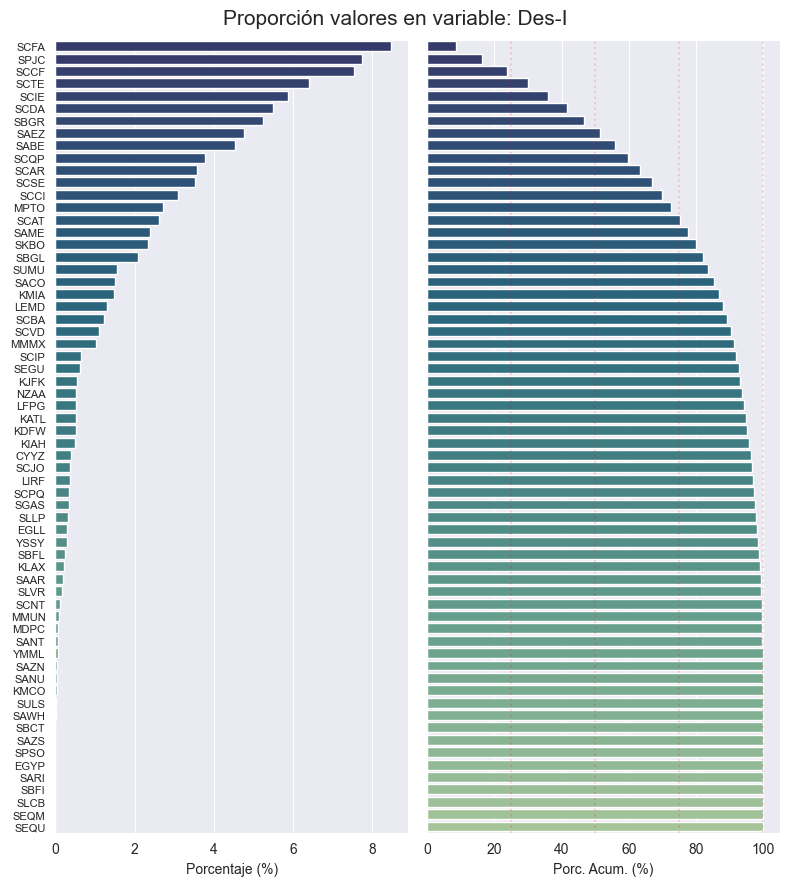

 *** [INFO] Cantidad de valores unicos: 64
---------------------------------------------------
Variable:  Des-O
Valores con mas registros:
  Des-O  cantidad  Porc.%  Acum.%
0  SCFA      5786    8.48    8.48
1  SPJC      5270    7.73   16.22
2  SCCF      5146    7.54   23.76
3  SCTE      4357    6.39   30.15
4  SCIE      3993    5.85   36.00
5  SCDA      3747    5.49   41.50
Valores con menos registros:
   Des-O  cantidad  Porc.%  Acum.%
60  KIAD         1     0.0   100.0
61  SPSO         1     0.0   100.0
62  EGYP         1     0.0   100.0


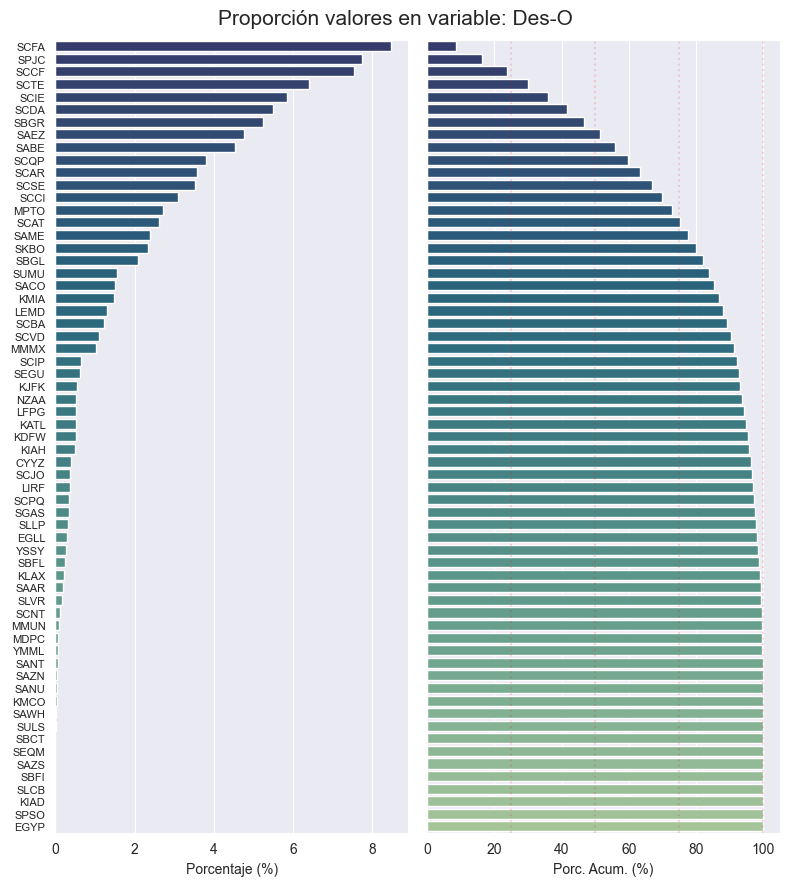

 *** [INFO] Cantidad de valores unicos: 63
---------------------------------------------------
Variable:  SIGLADES
Valores con mas registros:
       SIGLADES  cantidad  Porc.%  Acum.%
0  Buenos Aires      6335    9.29    9.29
1   Antofagasta      5786    8.48   17.78
2          Lima      5270    7.73   25.51
3        Calama      5146    7.54   33.05
4  Puerto Montt      4357    6.39   39.45
5    Concepcion      3993    5.85   45.30
Valores con menos registros:
          SIGLADES  cantidad  Porc.%  Acum.%
59  Puerto Stanley         1     0.0   100.0
60      Cochabamba         1     0.0   100.0
61      Washington         1     0.0   100.0


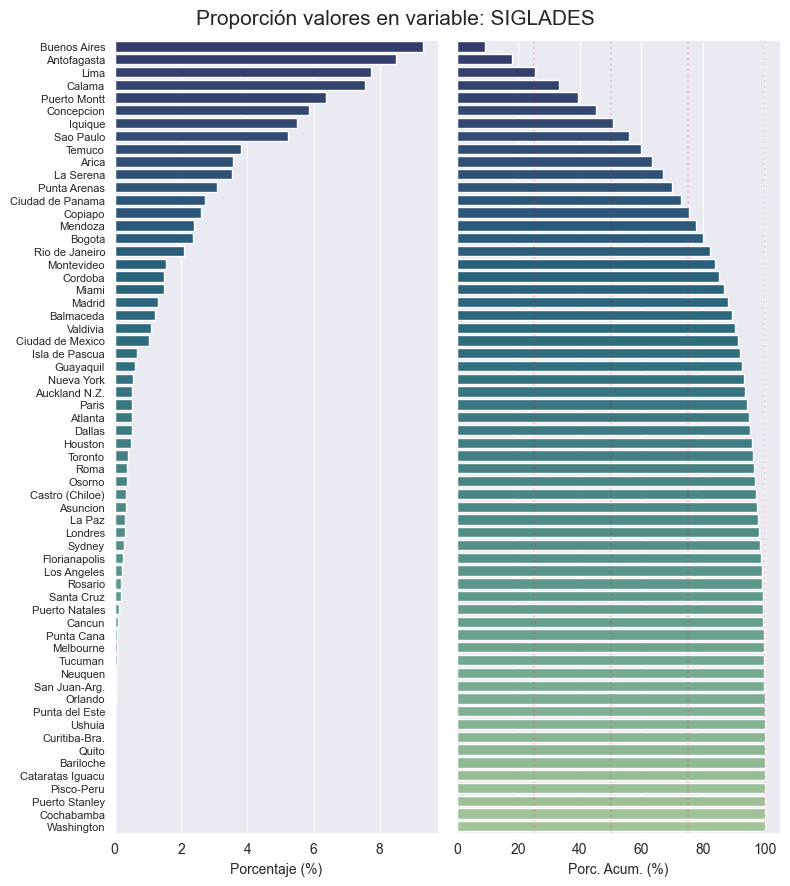

 *** [INFO] Cantidad de valores unicos: 62
---------------------------------------------------
Variable:  i_cod_des
Cantidad de registros por valor:
   i_cod_des  cantidad  Porc.%  Acum.%
0          1     68178   99.96   99.96
1          0        28    0.04  100.00
 *** [INFO] Cantidad de valores unicos: 2

 ========== AEROLINEA ============
---------------------------------------------------
Variable:  Emp-I
Valores con mas registros:
  Emp-I  cantidad  Porc.%  Acum.%
0   LAN     37611   55.14   55.15
1   SKU     14298   20.96   76.11
2   TAM      3049    4.47   80.58
3   ARG      1949    2.86   83.44
4   CMP      1850    2.71   86.15
5   LAW      1574    2.31   88.46
Valores con menos registros:
   Emp-I  cantidad  Porc.%  Acum.%
27   LPE         4    0.01   100.0
28   DSM         2    0.00   100.0
29   LNE         1    0.00   100.0


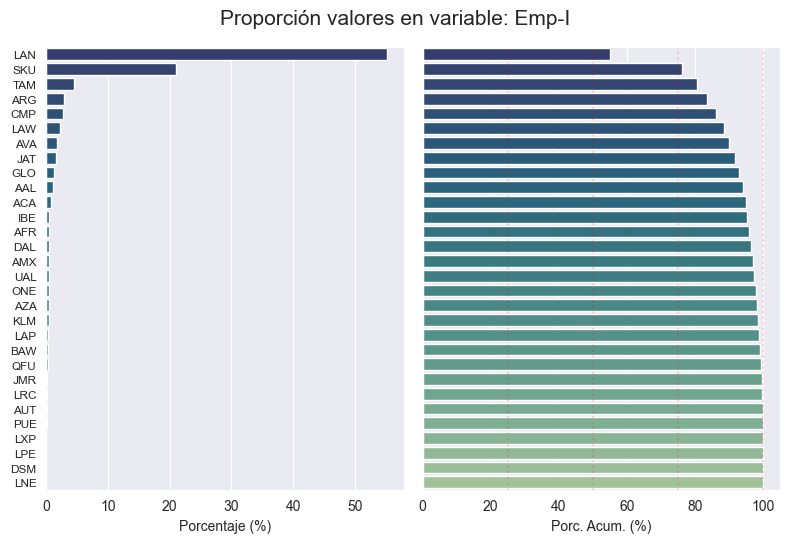

 *** [INFO] Cantidad de valores unicos: 30
---------------------------------------------------
Variable:  Emp-O
Valores con mas registros:
  Emp-O  cantidad  Porc.%  Acum.%
0   LAN     20988   30.77   30.78
1   LXP     14558   21.34   52.13
2   SKU     14298   20.96   73.10
3   TAM      3046    4.47   77.57
4   ARG      1946    2.85   80.42
5   CMP      1850    2.71   83.13
Valores con menos registros:
   Emp-O  cantidad  Porc.%  Acum.%
29   56R        17    0.02   99.99
30   48O        10    0.01  100.00
31   TPU         2    0.00  100.00


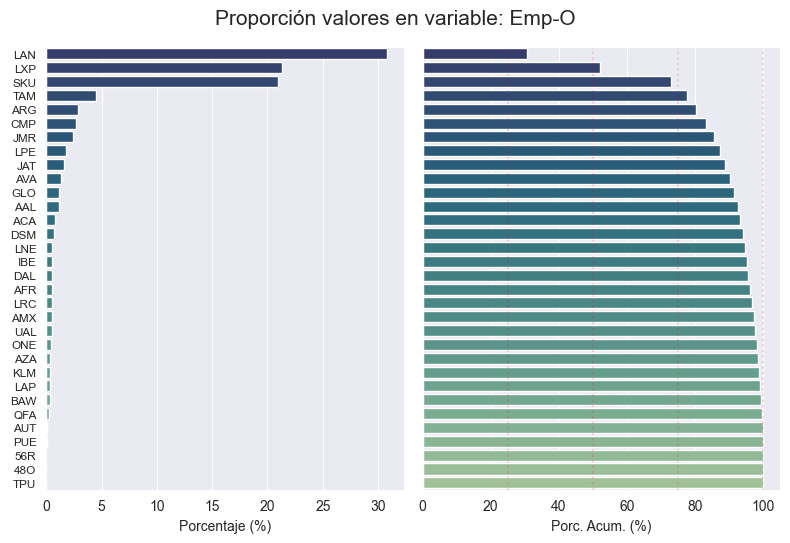

 *** [INFO] Cantidad de valores unicos: 32
---------------------------------------------------
Variable:  OPERA
Valores con mas registros:
                   OPERA  cantidad  Porc.%  Acum.%
0            Grupo LATAM     40892   59.95   59.96
1            Sky Airline     14298   20.96   80.93
2  Aerolineas Argentinas      1949    2.86   83.79
3               Copa Air      1850    2.71   86.50
4   Latin American Wings      1674    2.45   88.95
5                Avianca      1152    1.69   90.64
Valores con menos registros:
                       OPERA  cantidad  Porc.%  Acum.%
20                     Lacsa        92    0.13   99.82
21                   Austral        74    0.11   99.93
22  Plus Ultra Lineas Aereas        49    0.07  100.00


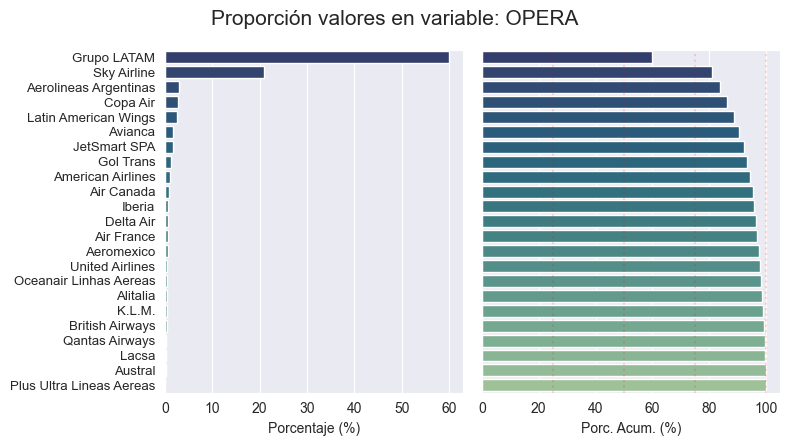

 *** [INFO] Cantidad de valores unicos: 23
---------------------------------------------------
Variable:  i_cod_emp
Cantidad de registros por valor:
   i_cod_emp  cantidad  Porc.%  Acum.%
0          1     49537   72.63   72.63
1          0     18669   27.37  100.00
 *** [INFO] Cantidad de valores unicos: 2

 ========== CODIGO DE VUELO ============
---------------------------------------------------
Variable:  Vlo-I
Valores con mas registros:
  Vlo-I  cantidad  Porc.%  Acum.%
0   174       686    1.01    1.01
1    11       645    0.95    1.97
2   116       608    0.89    2.86
3   150       557    0.82    3.68
4   704       556    0.82    4.50
5   162       553    0.81    5.31
Valores con menos registros:
    Vlo-I  cantidad  Porc.%  Acum.%
578  7959         1     0.0   100.0
579  7911         1     0.0   100.0
580  9956         1     0.0   100.0
 [Advertencia]: No se realizó grafico por tener muchos valores unicos
 *** [INFO] Cantidad de valores unicos: 581
-----------------------------

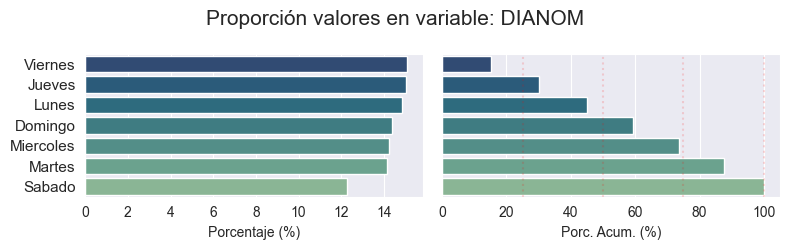

 *** [INFO] Cantidad de valores unicos: 7
---------------------------------------------------
Variable:  MESNOM
Cantidad de registros por valor:
       MESNOM  cantidad  Porc.%  Acum.%
0   Diciembre      6356    9.32    9.32
1       Enero      6108    8.96   18.28
2   Noviembre      6080    8.91   27.19
3     Octubre      6032    8.84   36.03
4       Julio      5992    8.79   44.82
5      Agosto      5744    8.42   53.24
6   Setiembre      5610    8.23   61.47
7     Febrero      5561    8.15   69.62
8       Marzo      5482    8.04   77.66
9        Mayo      5240    7.68   85.34
10      Abril      5020    7.36   92.70
11      Junio      4981    7.30  100.00


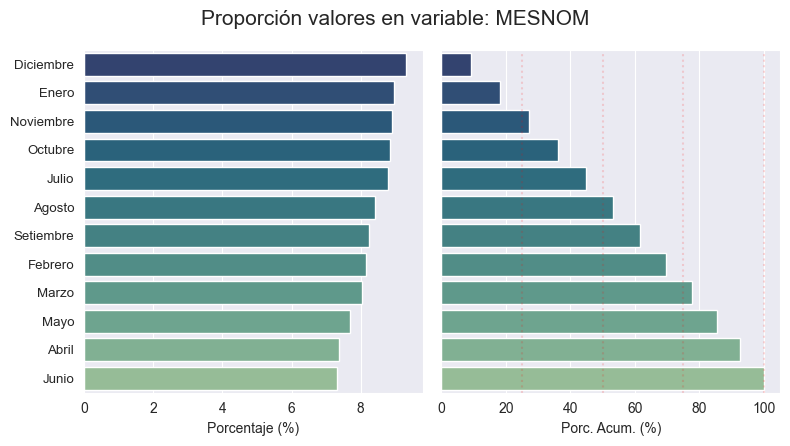

 *** [INFO] Cantidad de valores unicos: 12


In [327]:
# Ver detalle de cada variable categorica

# definir funcion para graficar
def graf_cat(datacat,variable):
    
    # separador
    print('---------------------------------------------------')
    sns.set_style("darkgrid") # seteo de tema de fondo
    
    # Titulo
    print('Variable: ',variable)
    
    conteo = datacat[[variable]] # seleccionar variable
    conteo["cantidad"] = 1   # variable auxiliar
    conteo = conteo.groupby(variable).agg(np.sum).sort_values("cantidad",ascending=False).reset_index() # conteo de valores por grupo
    conteo["Porc.%"] = np.round(100.0*conteo["cantidad"]/np.sum(conteo["cantidad"]),2) # calculo de densidad
    conteo["Acum.%"] = np.round(100.0*conteo["Porc.%"].cumsum()/conteo["Porc.%"].sum(),2) # calculo de acumulado     
    
    
    # Mostrar lista/tabla de cantidad de registros por valor unico en la variable
    if(conteo.shape[0] > 15):
        print('Valores con mas registros:')
        print(conteo.head(6))
        print('Valores con menos registros:')
        print(conteo.tail(3))
    else:
        print('Cantidad de registros por valor:')
        print(conteo)
    
    cantidad = conteo.shape[0] # cantidad de registros en dataframe agrupado
    
    
    # Determinar aspectos de tamaño de la figura y tamaño de letra
    if(cantidad < 10):
        figy = 2.5
        fontsize = 11.0
    elif(cantidad < 25):
        figy = 4.5
        fontsize = 9.5
    elif(cantidad < 45):
        figy = 5.5
        fontsize = 8.5
    elif(cantidad < 60):
        figy = 8.5
        fontsize = 8.5
    else:
        figy = 9.0
        fontsize = 8.0   
    
    
    # Graficar densidad y distribucion (acumulado), en caso posea al menos 5 y menor a 100 valores unicos
    if((cantidad > 4) & (cantidad < 100)):
        
        # paleta de color
        paleta = "crest_r"
        
        # Figura
        fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,figy))
        fig.suptitle('Proporción valores en variable: ' + str(variable),fontsize=15)
        
        # Grafica izquierda - Densidad
        x1 = sns.barplot(conteo,x="Porc.%",y=variable,palette=paleta,ax=ax[0])
        x1.set_yticklabels(conteo[variable], size = fontsize)
        
        # titulo y ejes
        ax[0].set_title("")
        ax[0].set_xlabel('Porcentaje (%)',fontsize=10)
        ax[0].set_ylabel("")
        
        # Grafica derecha - Densidad Acumulada (Distribucion)
        x2 = sns.barplot(conteo,x="Acum.%",y=variable,palette=paleta,ax=ax[1])
        x2.set_yticklabels(conteo[variable],size=fontsize)
        
        # Agregar lineas de referencia
        ax[1].axvline(x=25, color='r', label='25%',linestyle="dotted",alpha=0.15)
        ax[1].axvline(x=50, color='r', label='50%',linestyle="dotted",alpha=0.15)
        ax[1].axvline(x=75, color='r', label='75%',linestyle="dotted",alpha=0.15)
        ax[1].axvline(x=100, color='r', label='100%',linestyle="dotted",alpha=0.15)
        
        # titulo y ejes
        ax[1].set_title("")
        ax[1].set_xlabel('Porc. Acum. (%)',fontsize=10)
        ax[1].set_ylabel("")
        
        fig.tight_layout()
        plt.show()
    
    # en caso tenga demasiados valores unicos indicar
    elif(cantidad >= 100):
        print(' [Advertencia]: No se realizó grafico por tener muchos valores unicos')
    
    # Informacion de resumen final
    print(' *** [INFO] Cantidad de valores unicos:',cantidad)

### Graficar

# Segun tipo vuelo
print('\n ========== TIPO VUELO ============')
graf_cat(datacat,"TIPOVUELO")

# Segun origen
print('\n ========== ORIGEN ============')
graf_cat(datacat,"Ori-I")
graf_cat(datacat,"Ori-O")
graf_cat(datacat,"SIGLAORI")
graf_cat(datacat,"i_cod_ori")

# Segun destino
print('\n ========== DESTINO ============')
graf_cat(datacat,"Des-I")
graf_cat(datacat,"Des-O")
graf_cat(datacat,"SIGLADES")
graf_cat(datacat,"i_cod_des")

# Segun aerolinea
print('\n ========== AEROLINEA ============')
graf_cat(datacat,"Emp-I")
graf_cat(datacat,"Emp-O")
graf_cat(datacat,"OPERA")
graf_cat(datacat,"i_cod_emp")

# Segun vuelo
print('\n ========== CODIGO DE VUELO ============')
graf_cat(datacat,"Vlo-I")
graf_cat(datacat,"Vlo-O")
graf_cat(datacat,"i_cod_vlo")

# Segun fecha (Dia-Mes)
print('\n ========== FECHA ============')
graf_cat(datacat,"DIANOM")
graf_cat(datacat,"MESNOM")


**Observaciones**:
- Los datos corresponden al año `2017`.
- El 100% de los origenes son de S`antiago de Chile`.
- Los vuelos nacionales (`54.2%`) poseen mayor representacion a los internacionales (`45.8%`).
- Los destinos con mayor cantidad de vuelos registrados están en Sudamerica (Con mayor proporcion en Buenos Aires, Lima y Sao Paulo) 
- Las aerolineas (Emp-I/Emp-O) `LAN` y `SKU` poseen los porcentajes más altos de representación.
- El grupo LATAM posee la mayor representación en la variable OPERA con `59.95%`, seguido de SKU con `20.96%`. Entre ambas alcanzan el `80.91%` del total.
- Los meses de fin de año como `Diciembre` (9.32%) y `Enero` (8.96%) poseen mayor % de vuelos. 
- Los meses alrededor de mitad de año poseen menor % de vuelos. `Junio` (7.30%) es el mas bajo.
- Los días de mayor vuelo son `viernes` (15.09%), `jueves` (15.03%) y `lunes` (14.85%).
- El día mas bajo de % de vuelo es el `sábado` (12.25%).

___

**Importante Observado**: El dato observado según el indicador `i_cod_emp` es interesante debido a que significa que el codigo de la aerolinea programada no coincide con el de operación (`Emp-I != Emp-O`), con un porcentaje de *27.37%*. Para entender más detalles del mismo, revisaremos la distribución de otras variables.

___

In [328]:
# Seleccionar datos con el caso indicado de "i_cod_emp == 0"
df_emp = datacat[["Emp-I","Emp-O","OPERA","SIGLADES","i_cod_emp"]].copy()
df_emp = df_emp[df_emp["i_cod_emp"] == 0].copy() # filtrar aquellos donde hubo cambio entre Planificado y Operacional
df_emp.sample(5)

,Emp-I,Emp-O,OPERA,SIGLADES,i_cod_emp
59589,LAN,LXP,Grupo LATAM,La Serena,0
5909,LAN,LPE,Grupo LATAM,Lima,0
36085,LAN,LXP,Grupo LATAM,Puerto Montt,0
25442,LAN,LXP,Grupo LATAM,Puerto Montt,0
42425,LAN,LXP,Grupo LATAM,Antofagasta,0


---------------------------------------------------
Variable:  Emp-I
Cantidad de registros por valor:
  Emp-I  cantidad  Porc.%  Acum.%
0   LAN     16623   89.04   89.04
1   LAW      1574    8.43   97.47
2   AVA       267    1.43   98.90
3   QFU       195    1.04   99.94
4   ARG         5    0.03   99.97
5   TAM         3    0.02   99.99
6   AUT         2    0.01  100.00


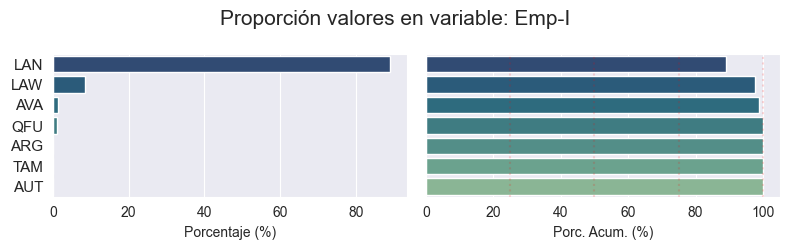

 *** [INFO] Cantidad de valores unicos: 7
---------------------------------------------------
Variable:  Emp-O
Cantidad de registros por valor:
   Emp-O  cantidad  Porc.%  Acum.%
0    LXP     14549   77.93   77.93
1    JMR      1547    8.29   86.22
2    LPE      1210    6.48   92.70
3    DSM       491    2.63   95.33
4    LNE       373    2.00   97.33
5    LRC       265    1.42   98.75
6    QFA       195    1.04   99.79
7    56R        17    0.09   99.88
8    48O        10    0.05   99.93
9    AUT         5    0.03   99.96
10   LAP         3    0.02   99.98
11   ARG         2    0.01   99.99
12   TPU         2    0.01  100.00


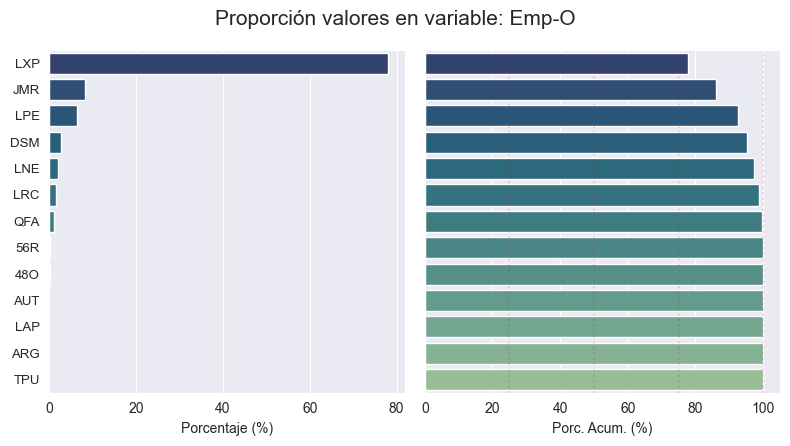

 *** [INFO] Cantidad de valores unicos: 13
---------------------------------------------------
Variable:  OPERA
Cantidad de registros por valor:
                   OPERA  cantidad  Porc.%  Acum.%
0            Grupo LATAM     16626   89.06   89.06
1   Latin American Wings      1574    8.43   97.49
2                Avianca       267    1.43   98.92
3         Qantas Airways       195    1.04   99.96
4  Aerolineas Argentinas         5    0.03   99.99
5                Austral         2    0.01  100.00


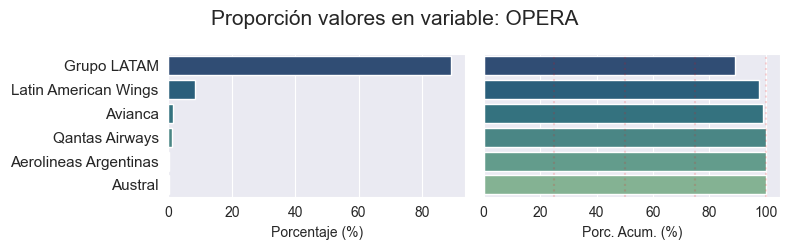

 *** [INFO] Cantidad de valores unicos: 6
---------------------------------------------------
Variable:  SIGLADES
Valores con mas registros:
       SIGLADES  cantidad  Porc.%  Acum.%
0    Concepcion      2700   14.46   14.46
1  Puerto Montt      2632   14.10   28.55
2          Lima      2288   12.26   40.81
3        Calama      1655    8.86   49.67
4   Antofagasta      1595    8.54   58.21
5     La Serena      1379    7.39   65.60
Valores con menos registros:
         SIGLADES  cantidad  Porc.%  Acum.%
19  San Juan-Arg.        35    0.19   99.97
20       Asuncion         3    0.02   99.99
21      Melbourne         1    0.01  100.00


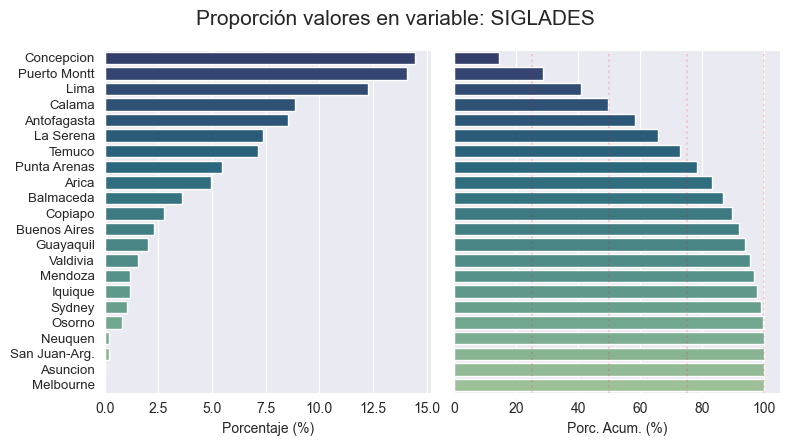

 *** [INFO] Cantidad de valores unicos: 22


In [329]:
# Generar graficas y tablas de densidades
graf_cat(df_emp,"Emp-I")
graf_cat(df_emp,"Emp-O")
graf_cat(df_emp,"OPERA")
graf_cat(df_emp,"SIGLADES")

___

**Observado**: Mediante lo anterior vemos que para el `Grupo LATAM` concentra cerca del *90%* de la casuistica indicada, donde los codigos de vuelo cambian. Posterior sería interesante la evaluación de si estos casos estan relacionados a los atrasos o no de vuelos, como una hipotesis de negocio a responder.

___

#### 3.3.2. Variables continuas

___
Previo a realizar el analisis, agregamos las siguientes variables:
- `dif_min` : Diferencia entre `Fecha-O` y `Fecha-I`, mide el atraso (en minutos) entre la hora que ocurrió respecto de la planificada
- `atraso_N` : variable indicadora que indica cuando se da atraso segun se cumpla la condicion: "`dif_min` > **N**"

___

In [330]:
# seleccionar variables continuas
datacon = data.select_dtypes(exclude=["object"]).copy()
datacon.head()

,Fecha-I,Vlo-I,Fecha-O,Vlo-O,DIA,MES,AÑO
0,2017-01-01 23:30:00,226,2017-01-01 23:33:00,226,1,1,2017
1,2017-01-02 23:30:00,226,2017-01-02 23:39:00,226,2,1,2017
2,2017-01-03 23:30:00,226,2017-01-03 23:39:00,226,3,1,2017
3,2017-01-04 23:30:00,226,2017-01-04 23:33:00,226,4,1,2017
4,2017-01-05 23:30:00,226,2017-01-05 23:28:00,226,5,1,2017


In [331]:
## Crear variables

# Variable de atraso de vuelo
datacon["dif_min"] = (datacon["Fecha-O"] - datacon["Fecha-I"]).dt.total_seconds()/60.0 # total de segundos convertir a minutos
datacon["dif_min"] = pd.to_numeric(datacon["dif_min"], errors="coerce",downcast="integer") # convertir a tipo entero

# Variable indicadora de atraso: Valor 1 si cataloga atrasado, 0 si no cataloga atrasado
datacon["atraso_10"] = 1*(datacon["dif_min"] > 10.0) # mas de 10 min es con atraso
datacon["atraso_15"] = 1*(datacon["dif_min"] > 15.0) # mas de 15 min es con atraso

## NOTA: La idea de "atraso_N" es generar una variable binaria para diferentes umbrales de atraso

In [332]:
# Descripcion general de los datos
datacon.describe()

,Vlo-I,Vlo-O,DIA,MES,AÑO,dif_min,atraso_10,atraso_15
count,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
mean,969.827288,967.421092,15.714790,6.622585,2017.000029,9.110855,0.274433,0.184940
std,2029.024762,2026.193621,8.782886,3.523321,0.005415,19.313387,0.446232,0.388252
min,1.000000,1.000000,1.000000,1.000000,2017.000000,-14.000000,0.000000,0.000000
25%,150.000000,150.000000,8.000000,3.000000,2017.000000,-1.000000,0.000000,0.000000
50%,300.000000,300.000000,16.000000,7.000000,2017.000000,4.000000,0.000000,0.000000
75%,632.000000,637.500000,23.000000,10.000000,2017.000000,12.000000,1.000000,0.000000
max,9956.000000,9956.000000,31.000000,12.000000,2018.000000,161.000000,1.000000,1.000000



 ========== ATRASO ============
---------------------------------------------------


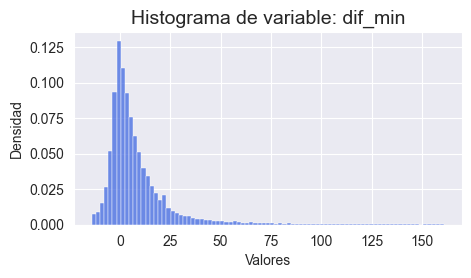

---------------------------------------------------
Variable:  atraso_10
Cantidad de registros por valor:
   atraso_10  cantidad  Porc.%  Acum.%
0          0     49488   72.56   72.56
1          1     18718   27.44  100.00
---------------------------------------------------


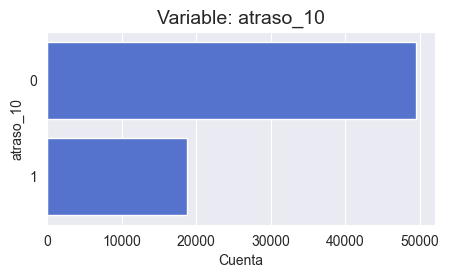

---------------------------------------------------
Variable:  atraso_15
Cantidad de registros por valor:
   atraso_15  cantidad  Porc.%  Acum.%
0          0     55592   81.51   81.51
1          1     12614   18.49  100.00
---------------------------------------------------


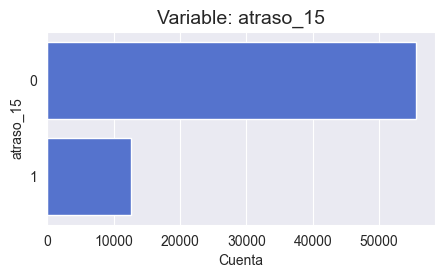


 ========== AÑO ============
---------------------------------------------------
Variable:  AÑO
Cantidad de registros por valor:
    AÑO  cantidad  Porc.%  Acum.%
0  2017     68204   100.0   100.0
1  2018         2     0.0   100.0

 ========== DIA ============
---------------------------------------------------
Variable:  DIA
Valores con mas registros:
   DIA  cantidad  Porc.%  Acum.%
0   20      2290    3.36    3.36
1   27      2286    3.35    6.71
2   12      2284    3.35   10.06
3   10      2283    3.35   13.41
4    6      2275    3.34   16.75
5   22      2272    3.33   20.08
Valores con menos registros:
    DIA  cantidad  Porc.%  Acum.%
27   18      2160    3.17   92.15
28   29      2044    3.00   95.15
29   30      2020    2.96   98.11
30   31      1290    1.89  100.00
---------------------------------------------------


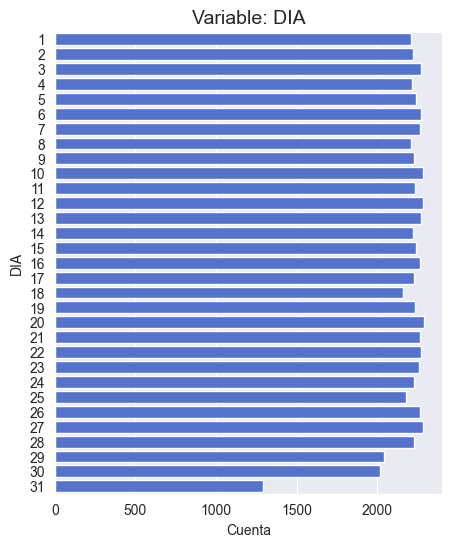


 ========== MES ============
---------------------------------------------------
Variable:  MES
Cantidad de registros por valor:
    MES  cantidad  Porc.%  Acum.%
0    12      6356    9.32    9.32
1     1      6108    8.96   18.28
2    11      6080    8.91   27.19
3    10      6032    8.84   36.03
4     7      5992    8.79   44.82
5     8      5744    8.42   53.24
6     9      5610    8.23   61.47
7     2      5561    8.15   69.62
8     3      5482    8.04   77.66
9     5      5240    7.68   85.34
10    4      5020    7.36   92.70
11    6      4981    7.30  100.00
---------------------------------------------------


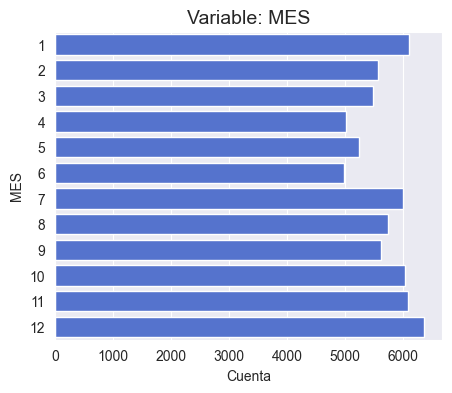


 ========== CODIGO DE VUELO ============
---------------------------------------------------


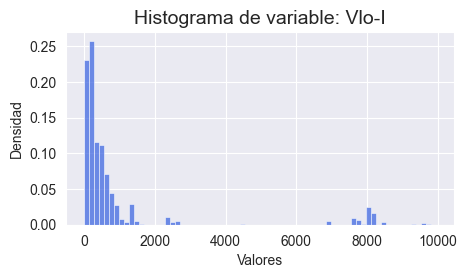

---------------------------------------------------


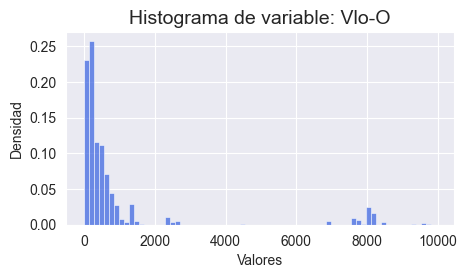

In [333]:
# Analizar variables continuas

# funcion para mostrar distribucion
def graf_cont(datos,variable,figx=5,figy=2.5,tipo=1,min=None,max=None,bins=None):
    
    # separador
    print('---------------------------------------------------')
    
    sns.set_style("darkgrid") # seteo de tema de fondo
    color = "royalblue"
    
    # Grafico de histograma - variable continua
    if(tipo==1):
        
        plt.figure(figsize=(figx,figy)) # grafica
        
        if(min and max and bins):
            ##plt.hist(datos[variable],bins=bins,color="cornflowerblue")
            b = sns.histplot(datos,x=variable,bins=bins,stat="proportion",color=color)
            plt.xlim([min,max])
            
        elif(bins):
            ##plt.hist(datos[variable],bins=bins,color="cornflowerblue")
            b = sns.histplot(datos,x=variable,bins=bins,stat="proportion",color=color)
            
        else:
            ##plt.hist(datos[variable],color="royalblue")
            b = sns.histplot(datos,x=variable,stat="proportion",color=color)
        
        ##plt.yaxis.set_major_formatter(PercentFormatter(1))  # colocar en formato porcentaje
        plt.title('Histograma de variable: ' + str(variable),fontsize=14)
        plt.xlabel("Valores",fontsize=10)
        plt.ylabel('Densidad',fontsize=10)
        plt.show()
    
    
    # Conteo de valores unicos en tabla - Formato tabla (No es grafica!)
    elif(tipo==2):
        
        print('Variable: ',variable)
        
        # Realizar el conteo de cada valor unico en la tabla y obtener tanto porcentaje (%) como el acumulado
        conteo = datos[[variable]]
        conteo["cantidad"] = 1
        conteo = conteo.groupby(variable).agg(np.sum).sort_values("cantidad",ascending=False).reset_index()
        conteo["Porc.%"] = np.round(100.0*conteo["cantidad"]/np.sum(conteo["cantidad"]),2) # calculo de densidad
        conteo["Acum.%"] = np.round(100.0*conteo["Porc.%"].cumsum()/conteo["Porc.%"].sum(),2) # calculo de acumulado     
        
        # Imprimir tabla de conteo de registros por cada valor unico de la variable
        if(conteo.shape[0] > 20):
            print('Valores con mas registros:')
            print(conteo.head(6))
            print('Valores con menos registros:')
            print(conteo.tail(4))
        else:
            print('Cantidad de registros por valor:')
            print(conteo)
    
    
    # Grafico de barras segun cantidad segun valores unicos de variable  
    elif(tipo==3):
        
        plt.figure(figsize=(figx,figy))
        b = sns.countplot(datos,y=variable,color=color)
        plt.ylabel(variable,fontsize=10)
        plt.title("Variable: " + str(variable),fontsize=14)
        plt.xlabel('Cuenta',fontsize=10)
        plt.show()
        
### Graficar-Calcular

# Atrasos
print('\n ========== ATRASO ============')
graf_cont(datacon,"dif_min",bins=85,tipo=1) # var. continua
graf_cont(datacon,"atraso_10",tipo=2) # 10 min 
graf_cont(datacon,"atraso_10",tipo=3) 
graf_cont(datacon,"atraso_15",tipo=2) # 15 min
graf_cont(datacon,"atraso_15",tipo=3) 

# Año
print('\n ========== AÑO ============')
graf_cont(datacon,"AÑO",tipo=2) 

# Dia
print('\n ========== DIA ============')
graf_cont(datacon,"DIA",min=1,tipo=2)
graf_cont(datacon,"DIA",figy=6,tipo=3)

# Mes
print('\n ========== MES ============')
graf_cont(datacon,"MES",tipo=2)
graf_cont(datacon,"MES",figy=4,tipo=3)

# Codigos de Vuelo
print('\n ========== CODIGO DE VUELO ============')
graf_cont(datacon,"Vlo-I",tipo=1,bins=70)
graf_cont(datacon,"Vlo-O",tipo=1,bins=70)

**Observado**: Se observa que la variable creada `dif_min`, la cual es la deseada, puesto que nos da información del atraso de vuelo, sigue una distribución normal con asimetría positiva (cola hacia la derecha), lo cual mediante transformación podría asemejarse a una distribución normal.
<br><br>
Por otro lado, las variables `Dia`, `Mes` y `Año`, si bien se vieron aqui como numericas, respetando el orden natural (ordinal), se pueden tratar como **categoricas**. En las gráficas anteriores, los histogramas tanto de `Dia` y `Mes` cumplen el propósito de mostrar la proporción de valores como valores continuos y/o como categorias.
- Para `Dia` se ve una proporción muy similar para todos los días, excepto para `29`,`30` y `31`. La menor proporción del día `31` es debido a que no todos los meses tienen este número.
- Para `Mes` vemos que los meses extremos del año como `Enero` y `Diciembre` esta la mayor proporción de vuelos. La menor proporción esta en el mes de `Junio`.

Adicionalmente es interesante ver como crear la variable indicadora `atraso_N` puede cambiar el porcentaje de vuelos que etiquetemos como atrasados:
- `atraso_10`: Con 10 min, el 27.44% seria con atraso
- `atraso_15`: Con 15 min, el 18.49% seria con atraso

En mi opinión es interesante esto, debido a que vemos que en un caso completamente estricto de considerar atraso en un vuelo porque la hora de operacion difiere en al menos 10 minutos con el planificado, tendriamos un **27.44%** de atrasos, mientras que si aplicamos un tiempo de espera de al menos 15 minutos, el porcentaje se reduce a menos del **20%**. Es decir, con **5** minutos adicionales, se reduce aprox. **9%** en la proporción.

___

## Desafio 1: ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

En los bloques anteriores (**`3.3.1 Variables continuas/ 3.3.2. Variables categoricas`**) se realizaron graficas-tablas con el analisis de la distribución de las variables disponibles, así como algunos comentarios especificos sobre detalles de interés.

Comentarios, impresiones y conclusiones respecto a los datos:
- Todos los vuelos tienen su origen en `Santiago de Chile` y son del año `2017`.
- Los vuelos nacionales (Chile) representan el **`54.2%`** y los internacionales el **`45.8%`**.
- Los vuelos internacionales que parten de Santiago de Chile poseen mayor proporción a ciudades de Sudamerica. Destinos con mayor proporcion: `Buenos Aires`, `Lima` y `Sao Paulo`.
- Me llama la atención que el grupo LATAM posea un **`59.95%`** de los vuelos, seguido de Sky Airline con **`20.96%`**. Entre ambos representan el `80.91%` de los vuelos.
- Es llamativo el **`27.37%`** de casos donde el código de la aerolinea planificada cambia respecto al operacional, teniendo en cuenta que de estos casos el **`89%`** es del grupo LATAM. Esto podria significar que se planificó con LATAM, pero la ejecución operacional la realizó otra.
- Me llama la atención que el día **`sábado`** posea menor proporción de vuelos respecto a los demás dias.
- Los meses de **`Diciembre`** y **`Enero`** posean un porcentaje mas álto de vuelos, lo cual a priori podría deberse a fiestas navideñas y vacaciones de verano.
- El mes de `Junio` posee menor porcentaje de vuelos.
- Los días del mes poseen una proporción muy similar, excepto por `29`,`30` y `31`, los cuales no hay en todos los meses (especialmente el dia 31).
- En cuanto a la variable de interés (atraso de vuelo), vemos que considerando un tiempo de atraso de **`15 min`** tendríamos el **`18.49%`** de los vuelos etiquetados como atrasados. Esto aproximando al 20% equivale a decir que en promedio `por cada 4 vuelos sin atraso hay 1 vuelo atrasado`.
- Me parece interesante que al comparar `atraso_10` y `atraso_15`, la diferencia de **5 minutos**, genera una diferencia de aprox. **9%** en la cantidad de vuelos con atraso. 

Tener en cuenta lo siguiente:
- Las variables `Ori-I`,`Ori-O` y `SIGLAORI` no se usarán porque poseen un valor único respecto al origen que es Santiago de Chile
- La variable `AÑO` porque el valor 2017 es casi la totalidad. (Hay 2 registros con año 2018)
- La variable código de vuelo `Vlo-I` y `Vlo-O`, debe tenerse cuidado al usarse como variable categorica, puesto que puede agregar **alta cardinalidad**
- Las variables `Dia` y `Mes` se pueden trabajar como variables categoricas, con la consideración de que tienen orden (ordinales).


___

## Desafio 2: Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv

In [334]:
# Creacion de variables segun Desafio 2

### Nota: Puesto que se piden algunas condiciones con Fecha-I crearemos un dataframe auxiliar
dfa = data[["Fecha-I"]].copy()

# La fecha la segmentamos en sus valores constituyentes (mes-dia-hora-minuto)
dfa["mes"] = dfa["Fecha-I"].dt.month
dfa["dia"] = dfa["Fecha-I"].dt.day
dfa["hora"] = dfa["Fecha-I"].dt.hour
dfa["minuto"] = dfa["Fecha-I"].dt.minute

# Se hace un pequeño artificio que permitirá seleccionar rangos de "mes-dia" y "hora-minuto" 
dfa["mes_dia"] = np.round(dfa["mes"] + (dfa["dia"]/100),2) # El entero es el mes y decimales los dias
dfa["hora_min"] = np.round(dfa["hora"] + (dfa["minuto"]/100),2) # El entero es la hora y decimales los minutos
dfa.sample(5) # aleatoriamente escogemos 8 registros

,Fecha-I,mes,dia,hora,minuto,mes_dia,hora_min
21912,2017-04-19 22:15:00,4,19,22,15,4.19,22.15
54921,2017-10-02 00:10:00,10,2,0,10,10.02,0.10
22816,2017-05-01 07:10:00,5,1,7,10,5.01,7.10
9298,2017-02-26 19:45:00,2,26,19,45,2.26,19.45
10670,2017-02-21 20:10:00,2,21,20,10,2.21,20.10


In [335]:
# Creación de datos adicionales

## variable: "temporada_alta"
condiciones = (
    ((dfa["mes_dia"] >= 12.15) | (dfa["mes_dia"] <= 3.03)) | 
    ((dfa["mes_dia"] >= 7.15) & (dfa["mes_dia"] <= 7.31)) |
    ((dfa["mes_dia"] >= 9.11) & (dfa["mes_dia"] <= 9.30)))
data["temporada_alta"] = 1*condiciones


## variable: "dif_min"
data["dif_min"] = (data["Fecha-O"] - data["Fecha-I"]).dt.total_seconds()/60.0 # total de segundos convertir a minutos
data["dif_min"] = pd.to_numeric(data["dif_min"], errors="coerce",downcast="integer") # convertir a tipo entero

## variable: "atraso_15"
data["atraso_15"] = 1*(data["dif_min"] > 15)


## variable: "periodo_dia"
def periodo_dia(x):
    valor = x.hora_min
    if((valor >= 5.0) & (valor <= 11.59)):
        return "mañana"
    elif((valor >= 12.0) & (valor <= 18.59)):
        return "tarde"
    else:
        return "noche"
data["periodo_dia"] = dfa.apply(periodo_dia,axis=1)
### NOTA: Aplicamos sobre el datafame auxiliar, teniendo cuidado de no hacer algun "sort" previamente

# Borramos de memoria el dataframe auxiliar
del dfa

# ver datos
data.sample(5) # escoger aleateoriamente 8 registros

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM,temporada_alta,dif_min,atraso_15,periodo_dia
22718,2017-05-23 02:21:00,174,SCEL,MPTO,CMP,2017-05-23 02:16:00,174,SCEL,MPTO,CMP,...,Martes,I,Copa Air,Santiago,Ciudad de Panama,Mayo,0,-5,0,noche
40776,2017-08-24 06:00:00,802,SCEL,SPJC,SKU,2017-08-24 05:58:00,802,SCEL,SPJC,SKU,...,Jueves,I,Sky Airline,Santiago,Lima,Agosto,0,-2,0,mañana
13215,2017-03-17 06:30:00,120,SCEL,SCCF,SKU,2017-03-17 06:29:00,120,SCEL,SCCF,SKU,...,Viernes,N,Sky Airline,Santiago,Calama,Marzo,0,-1,0,mañana
46478,2017-09-02 11:00:00,69,SCEL,SCPQ,LAN,2017-09-02 11:05:00,69,SCEL,SCPQ,LAN,...,Sabado,N,Grupo LATAM,Santiago,Castro (Chiloe),Setiembre,0,5,0,mañana
18581,2017-04-19 07:20:00,110,SCEL,SCAT,SKU,2017-04-19 07:16:00,110,SCEL,SCAT,SKU,...,Miercoles,N,Sky Airline,Santiago,Copiapo,Abril,0,-4,0,mañana


In [336]:
# Seleccionar variables indicadas en "Desafio 2" y exporarlas a archivo CSV

variables = ["temporada_alta","dif_min","atraso_15","periodo_dia"]
data[variables].copy().head()

,temporada_alta,dif_min,atraso_15,periodo_dia
0,1,3,0,noche
1,1,9,0,noche
2,1,9,0,noche
3,1,3,0,noche
4,1,-2,0,noche


In [337]:
# Guardar a CSV

nombre_archivo = "synthetic_features.csv"
data[variables].copy().to_csv(nombre_archivo,index=True,sep=",")
print('Se guardaron variables creadas en:',nombre_archivo)

Se guardaron variables creadas en: synthetic_features.csv


Se guardó al CSV con nombre `synthetic_features.csv`, las 4 variables creadas indicadas.

## Desafio 3: ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

In [374]:
# Formateo de datos y seleccion

data["DIA"] = data["DIA"].map(str)
data["MES"] = data["MES"].map(str)
data["temporada_alta"] = data["temporada_alta"].map(str)

variables = ["Des-O","SIGLADES","OPERA","MES","DIANOM","temporada_alta","TIPOVUELO","atraso_15"] # variables indicadas en pregunta
data[variables].head()

,Des-O,SIGLADES,OPERA,MES,DIANOM,temporada_alta,TIPOVUELO,atraso_15
0,KMIA,Miami,American Airlines,1,Domingo,1,I,0
1,KMIA,Miami,American Airlines,1,Lunes,1,I,0
2,KMIA,Miami,American Airlines,1,Martes,1,I,0
3,KMIA,Miami,American Airlines,1,Miercoles,1,I,0
4,KMIA,Miami,American Airlines,1,Jueves,1,I,0


En la exploración vimos que algunas variables como `Des-O`, `SIGLADES` y `OPERA` tienen una cantidad importante de valores únicos, dentro de las cuales algunas poseen una baja representatividad (pocos registros respecto al total), por lo que se podría aplicar una estrategia para agruparlos en un grupo bajo una misma etiqueta, con el fin de reducir la **"alta ordinalidad"** que es cuando una variable categorica posee muchos valores únicos.

In [375]:
# [Funcion auxiliar] Agrupar valores con poca representatividad de una variable en una sola etiqueta
def agrupa_categ(datos,variable,densidad=1,porc_min=0.0,etiqueta="varios"):
    # datos : dataframe con los datos a transformar
    # variable : es la variable a usar para la reducción de valores con poca proporción
    # densidad: Si es 1 se filtra segun densidad, si es 0 por acumulado se filtra
    # porc_min: Umbral para el agrupamiento
    # etiqueta: Valor a colocar a aquellos valores agrupados
    
    # Calculo de proporción de cada valor
    conteo = datos[[variable]].copy()
    conteo["cantidad"] = 1  # contador
    conteo = conteo.groupby(variable).agg(np.sum).sort_values("cantidad",ascending=False).reset_index() # conteo de valores por grupo
    
    # Calculo de densidad y acumulaod
    conteo["Porc.%"] = np.round(100.0*conteo["cantidad"]/np.sum(conteo["cantidad"]),2) # calculo de densidad 
    conteo["Acum.%"] = np.round(100.0*conteo["Porc.%"].cumsum()/conteo["Porc.%"].sum(),2) # calculo de acumulado
    
    # Aplicar agrupamiento de valores con baja representatividad segun densidad o acumulado
    if(densidad):
        # Valor con una representatividad menor a este umbral se filtran
        valores = conteo[conteo["Porc.%"] < porc_min][variable].unique().tolist()
    else:
        # En el acumulado la logica es inversa. Por encima de este valor se filtran
        valores = conteo[conteo["Acum.%"] > porc_min][variable].unique().tolist()
    
    # Asignar etiqueta a aquellos valores a agrupar
    datos_nuevo = datos.copy()
    indices = datos_nuevo[datos_nuevo[variable].isin(valores)].index
    datos_nuevo.loc[indices,variable] = etiqueta
    
    return datos_nuevo

A continuación se realizarán unas graficas que contienen los siguientes aspectos:
- La barra `azul claro` representa la cantidad total de registros (en %) para ese valor de la variable
- La barra `celeste/cyan` representa la cantidad de registros con `atraso_15 == 1` para ese valor de la variable
- La linea `azul oscuro` muestra la proporción de `(atraso_15 == 1)/registros_totales` para el valor en particular de la variable


**Ejemplo**: Para la variable `SIGLADES`, se tiene el valor `Buenos Aires` con aprox. 9.29% (6335 registros) del total, de estos alrededor del 25.5% poseen atraso (`atraso_15 == 1`). Esto en la grafica se entiende: La barra `azul claro` va representar el `9.29%`, mientras que la barra `celeste/cyan` va representar el `25.5%` de vuelos con atraso. Esta misma proporción (25.5%) se va mostrar en un eje paralelo, mediante la linea `azul oscuro`, para visualizar solamente las proporciones de `atraso_15==1` por cada valor de la variable `SIGLADES`.

---------------------------------------------------
Variable: Des-O
Porcentaje minimo de filtro (%):  0.0
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


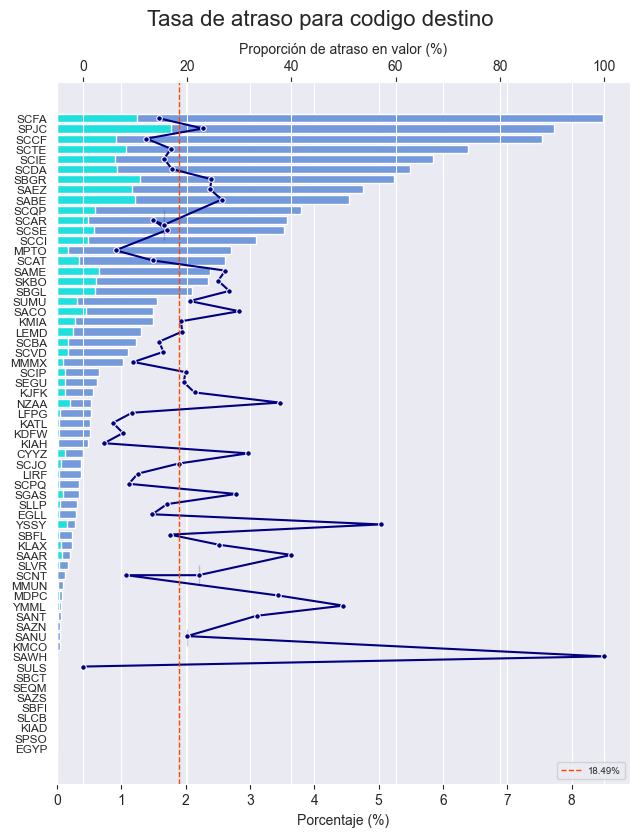

---------------------------------------------------
Variable: SIGLADES
Porcentaje minimo de filtro (%):  0.0
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


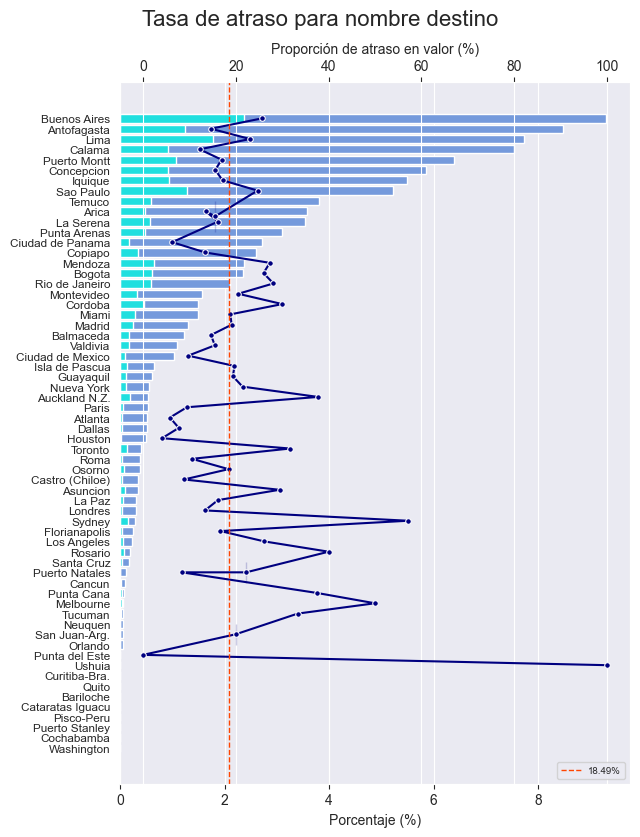

---------------------------------------------------
Variable: OPERA
Porcentaje minimo de filtro (%):  0.0
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


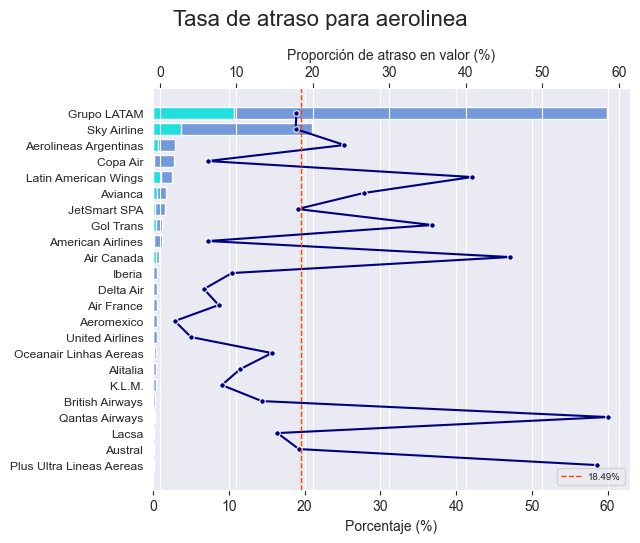

---------------------------------------------------
Variable: MES
Porcentaje minimo de filtro (%):  0.0
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


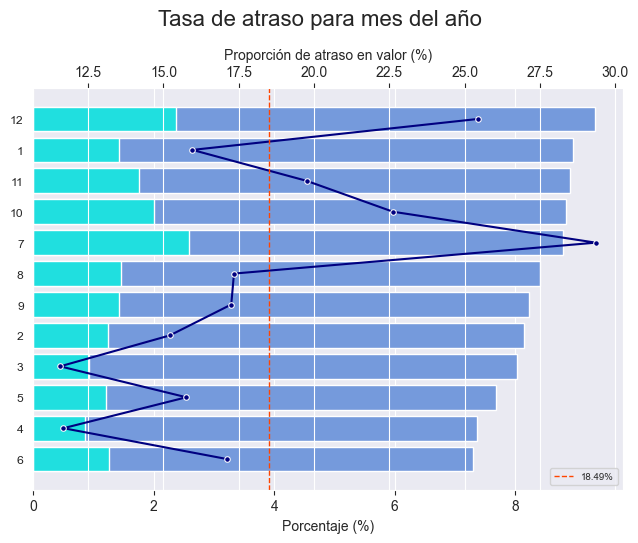

---------------------------------------------------
Variable: DIANOM
Porcentaje minimo de filtro (%):  0.0
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


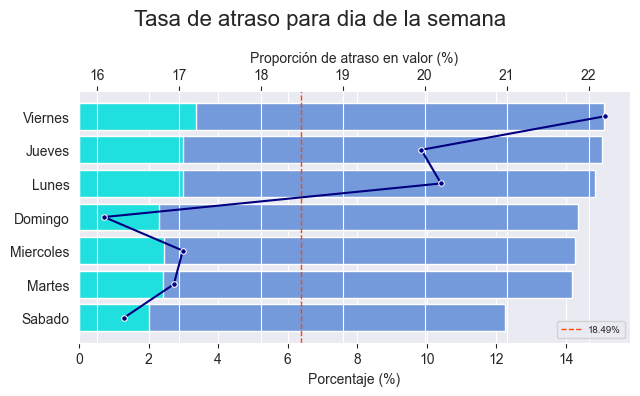

---------------------------------------------------
Variable: temporada_alta
Porcentaje minimo de filtro (%):  0.0
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


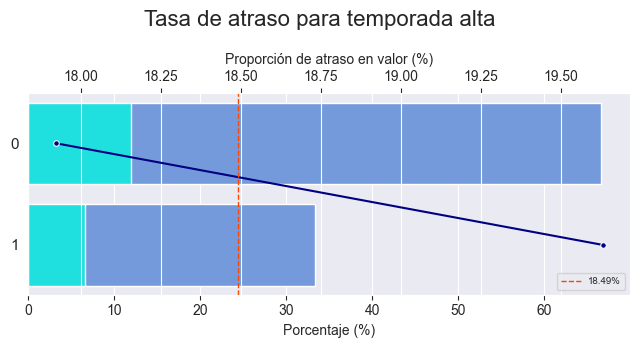

---------------------------------------------------
Variable: TIPOVUELO
Porcentaje minimo de filtro (%):  0.0
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


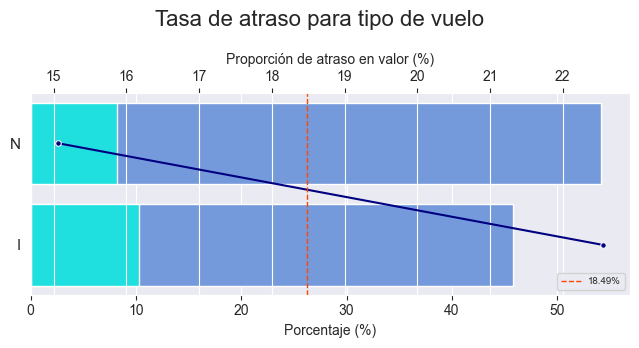

In [383]:
# Graficos de barras para analisis de variable indicadora "atraso_15" con respecto a las seleccionadas

def graf_dist(datacat,variable,variable_y="atraso_15",titulo="",agrupa_dens=1,porc_min=0.0,agrupa_etiq="VARIOS",valor_ref=1,ordenar_ref=0,figx=6.5):
    # datacat: dataframe con datos
    # variable: variable independiente que desea evaluarse la proporción
    # variable_y : variable dependiente
    # titulo: Indicar el texto a colocar que describa mejor a "variable"
    # porc_min : En caso se deseen agrupar los valores de menor proporción en otro grupo llamado "varios"
    # agrupa_dens : Estrategia par aagrupamiento de valores, por densidad (1) o acumulado (0)
    # agrupa_etiq : Valor de la etiqueta al agrupamiento.
    # valor_ref : El valor de referencia a usar segun "variable_y" (suele tener valor 0 y 1)
    # ordenar_ref : Ordenar los valores en la grafica según la proporción en el valor de referencia (valor_ref)
    # figx : Tamaño de figura en ancho
    
    print('---------------------------------------------------')
    sns.set_style("darkgrid") # seteo de tema de fondo
    print('Variable:',variable) # informativo
    print('Porcentaje minimo de filtro (%): ',porc_min)
    
    # En caso no se de un titulo, colocar por defecto
    if(titulo == ""):
        titulo = variable
    
    ###############################################
    ## Agrupar valores de baja representatividad ##
    datacat = agrupa_categ(datacat.copy(),variable,densidad=agrupa_dens,porc_min=porc_min,etiqueta=agrupa_etiq)
    
    
    #################################################
    ### Calculo de Chi-cuadrado para correlacion ####
    
    tabla = pd.crosstab(datacat[variable],datacat[variable_y])
    chi2 = chi2_contingency(tabla)
    testchi = "Hay dependencia al 5%" if chi2[1] < 0.05 else "Hay independencia al 5%" 
    print('Prueba Chi2 :: p-value: ',np.round(chi2[1],5),' ; ',testchi)
    
    
    #########################################################
    ## Generar estadisticas de los valores en la variable ###
    
    # Calculo de proporción de valores en variable
    conteo = datacat[[variable]].copy()
    conteo["cantidad"] = 1  # contador
    conteo = conteo.groupby(variable).agg(np.sum).sort_values("cantidad",ascending=False).reset_index() # conteo de valores por grupo
    conteo["Porc.%"] = np.round(100.0*conteo["cantidad"]/np.sum(conteo["cantidad"]),2) # calculo de densidad
    

    # Se filtra según el valor de "referencia" de la variable de interes (Y)
    conteo2 = datacat[[variable,variable_y]].copy()
    conteo2 = conteo2[conteo2[variable_y]==valor_ref][[variable]].copy()
    conteo2["cantidad"] = 1  # contador
    conteo2 = conteo2.groupby(variable).agg(np.sum).sort_values("cantidad",ascending=False).reset_index() # conteo de valores por grupo
    
    # Mergeo entre dataframes - Se unen los datos segun total y valor de referencia
    conteo = pd.merge(conteo,conteo2,how="left",on=variable)
    conteo = conteo.fillna(0) # En caso exista alguna categoria sin valor, reemplazar con valor 0%, puesto que no tiene registros
    conteo["[" + str(valor_ref) + "] Porc.%"] = np.round(conteo["Porc.%"]*(conteo["cantidad_y"]/conteo["cantidad_x"]),2) # calculo de densidad
    del conteo2
    
    # Ordenar segun valor de referencia. 
    if(ordenar_ref):
        conteo.sort_values("[" + str(valor_ref) + "] Porc.%",ascending=False,inplace=True)
    
    
    ##################################################################
    ### Valores con la etiqueta de agrupamiento colocarlos al final ##
    
    fila = conteo[conteo[variable].isin([agrupa_etiq])].copy()
    conteo = conteo[~conteo[variable].isin([agrupa_etiq])].copy()
    conteo = pd.concat([conteo.copy(),fila])
    conteo. reset_index(inplace=True)
    ######################################
    
    
    # Calculo de porcentajes acumulados
    conteo["Acum.%"] = np.round(100.0*conteo["Porc.%"].cumsum()/conteo["Porc.%"].sum(),2)  
    conteo["[" + str(valor_ref) + "] Acum.%"] = np.round(conteo["[" + str(valor_ref) + "] Porc.%"].cumsum(),2) 
    
    # Valor medio de 0/1 en variable objetivo
    conteo["Promedio [" + str(valor_ref) + "]"] = np.round(100.0*conteo["[" + str(valor_ref) + "] Porc.%"]/conteo["Porc.%"],2)
    
    ### NOTA: El dataframe "conteo" tiene los KPI´s a usar
    #########################

    cantidad = conteo.shape[0] # cantidad de registros en dataframe agrupado
    
    # Determinar aspectos de tamaño de la figura y tamaño de letra
    fontsize = 8.50
    figy = 3.5
    if(cantidad < 4):
        fontsize = 11.0
    elif(cantidad < 10):
        figy = 4.0
        fontsize = 10.0
    elif(cantidad < 25):
        figy = 5.5
        fontsize = 8.75
    elif(cantidad < 45):
        figy = 6.5
    elif(cantidad < 60):
        figy = 7.5
    else:
        figy = 8.5
    
    
    ##############################
    ## Generacion de graficas ###
        
    ## Colores
    color_total = "cornflowerblue"
    color_ref = "cyan"
    color_linea = "navy"
    
    # Figura
    fig, ax = plt.subplots(1,1,figsize=(figx,figy))
    
    # Barplot principal [1]
    x1 = sns.barplot(conteo,x="Porc.%",y=variable,color=color_total,ax=ax)
    x1.set_yticklabels(conteo[variable], size = fontsize)
    
    # Barplot secundario [2]
    sns.barplot(conteo,x="["+ str(valor_ref)+ "] Porc.%",y=variable,color=color_ref,ax=ax)
    
    # LinePlot [3] - Con eje de escala adicional (Comparte con eje principal)
    xx1 = x1.twiny() # eje paralelo
    sns.lineplot(conteo, x="Promedio [" +str(valor_ref)+ "]",y=x1.get_yticks(),
                 marker='o', markersize=4, color=color_linea, sort=False, ax=xx1)
    
    # Trazar una recta en el valor promedio de promedio de (# vuelos atrasados/ # vuelos totales)
    prop_prom = np.round(100.*datacat[datacat[variable_y]==valor_ref].shape[0]/datacat.shape[0],2)
    xx1.axvline(prop_prom,color="orangered",linestyle="dashed",linewidth=1,label=str(prop_prom)+"%")
    
    # titulo y ejes
    titulo_inicio = "Tasa de atraso para "
    fig.suptitle(titulo_inicio + titulo,fontsize=16)
    ax.set_xlabel('Porcentaje (%)',fontsize=10)
    xx1.set_xlabel("Proporción de atraso en valor (%)",fontsize=10)
    ax.set_ylabel("")
    
    if(ordenar_ref):
        ax.set_title("Ordenado según referencia") # en caso se indique ordenado
    
    plt.legend(loc ="lower right",fontsize=7.0)
    fig.tight_layout()
    plt.show()

#############################################
# Generar graficas para variables seleccionadas
titulos = ["codigo destino","nombre destino","aerolinea","mes del año","dia de la semana","temporada alta","tipo de vuelo"]
for i in range(len(variables[:-1])):
    graf_dist(data.copy(),variables[i],variable_y="atraso_15",titulo=titulos[i])

Por otro lado, para las variables con muchos valores únicos se va evaluar el agrupamiento de aquellos con menor representatividad y etiquetarlos como `VARIOS`. Visualizamos:

---------------------------------------------------
Variable: Des-O
Porcentaje minimo de filtro (%):  0.75
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


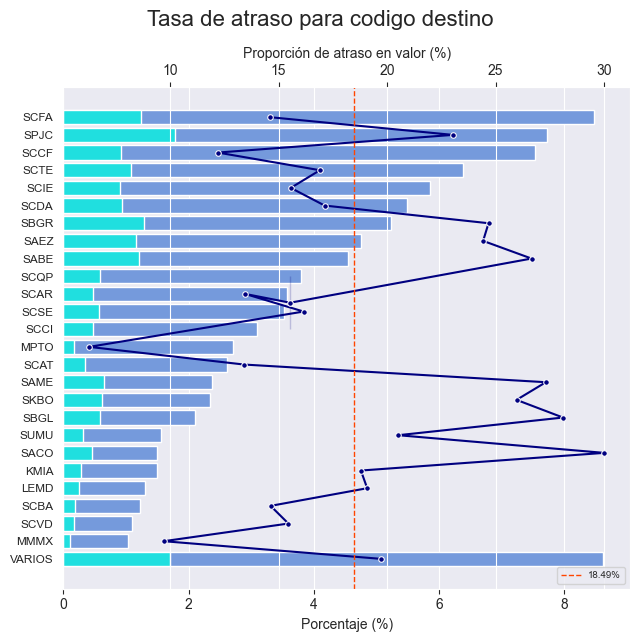

---------------------------------------------------
Variable: SIGLADES
Porcentaje minimo de filtro (%):  0.75
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


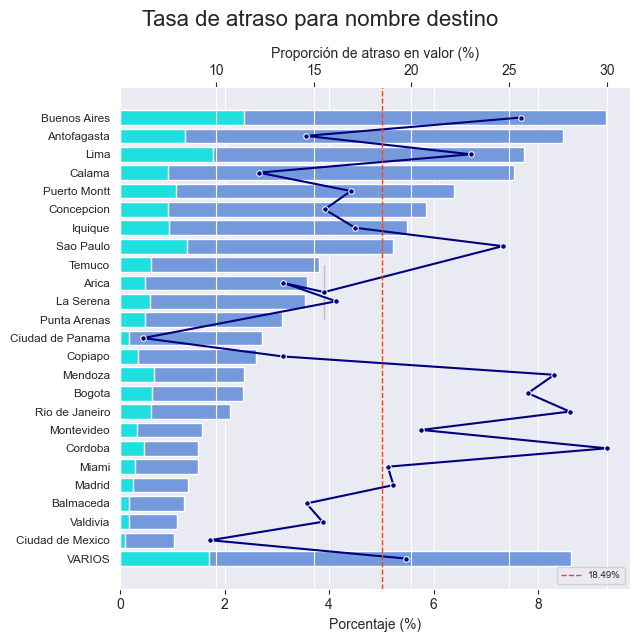

---------------------------------------------------
Variable: OPERA
Porcentaje minimo de filtro (%):  1.1
Prueba Chi2 :: p-value:  0.0  ;  Hay dependencia al 5%


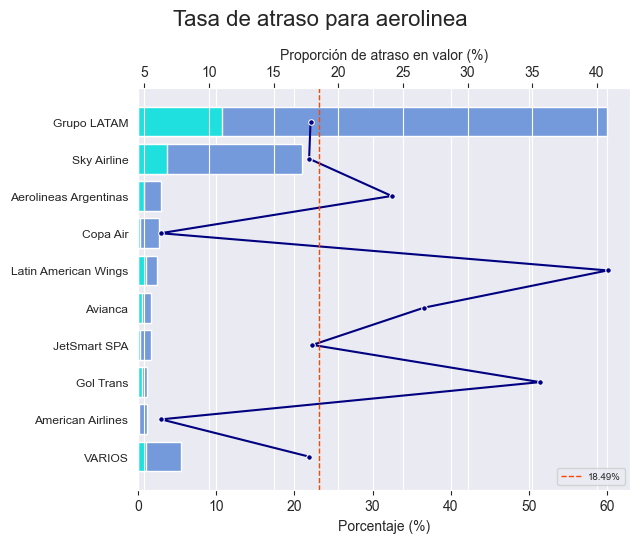

In [384]:
# Ahora s
graf_dist(data.copy(),"Des-O",variable_y="atraso_15",titulo="codigo destino",porc_min=0.75)
graf_dist(data.copy(),"SIGLADES",variable_y="atraso_15",titulo="nombre destino",porc_min=0.75)
graf_dist(data.copy(),"OPERA",variable_y="atraso_15",titulo="aerolinea",porc_min=1.10)

**De forma adicional**, dado que la variable creada para la tasa de atraso se calcula a partir del "tiempo de atraso" (`dif_min`), considero ver la distribución de estos valores continuos mediante Boxplot pueden complementar las relaciones analizadas previamente.

Rango de analisis de tiempo de atraso [minutos] :: minimo: -30  ; maximo: 70
---------------------------------------------------
Variable: Des-O


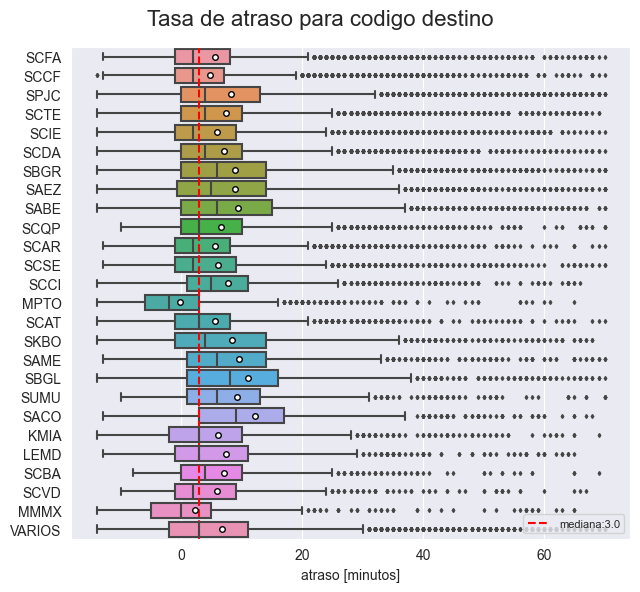

---------------------------------------------------
Variable: SIGLADES


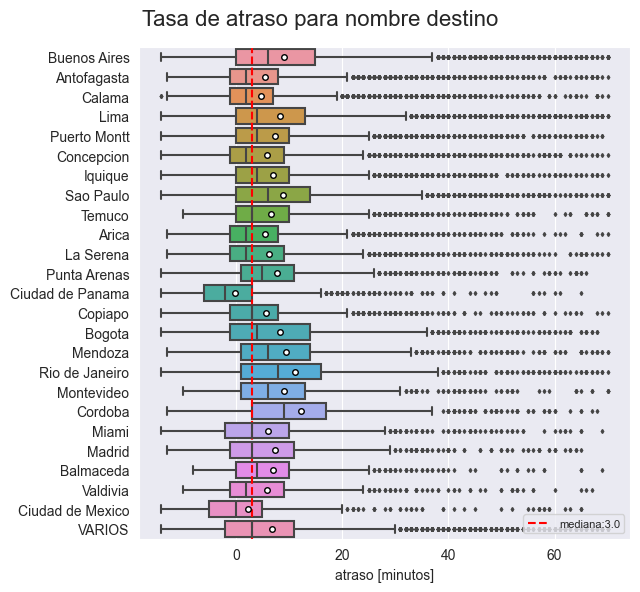

---------------------------------------------------
Variable: OPERA


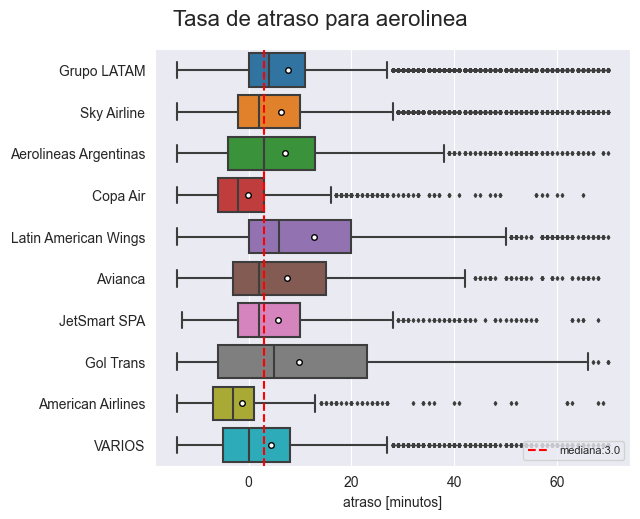

---------------------------------------------------
Variable: MES


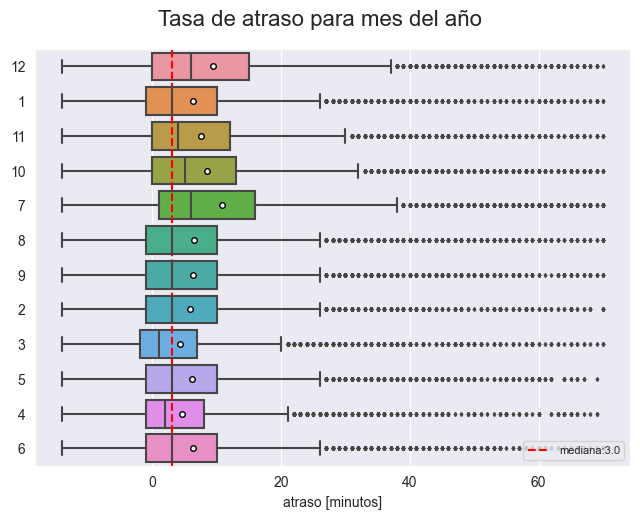

---------------------------------------------------
Variable: DIANOM


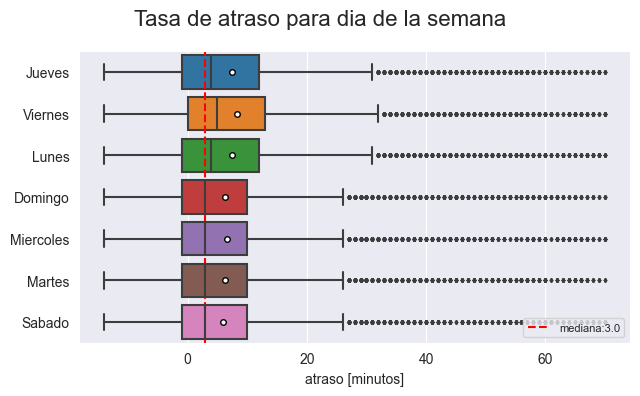

---------------------------------------------------
Variable: temporada_alta


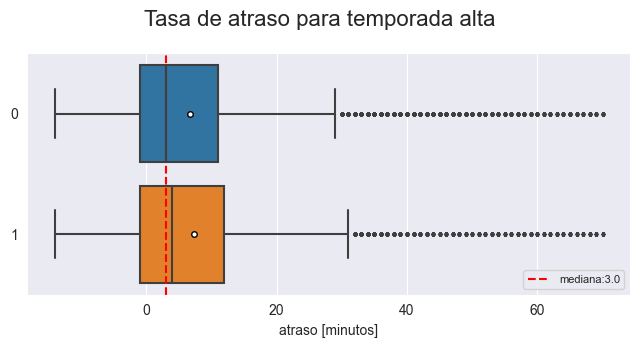

---------------------------------------------------
Variable: TIPOVUELO


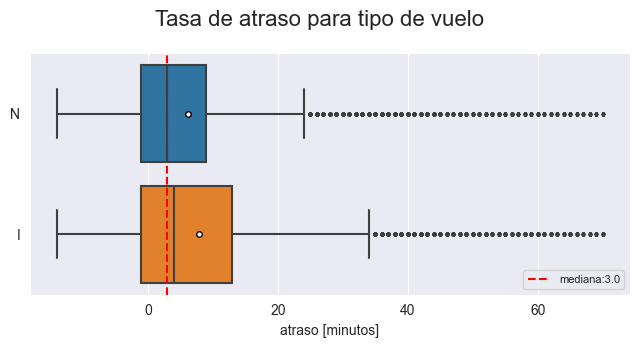

In [385]:
# Boxplot con variable "minutos de atraso" (dif_min)

def graf_boxplot(datacat,variable,variable_y="dif_min",titulo="",agrupa_dens=1,porc_min=0.0,agrupa_etiq="VARIOS",ordenar_ref=0,aplica_limites=0,miny=-10,maxy=60,figx=6.5):
    
    # datacat: dataframe con datos
    # variable: variable independiente que desea evaluarse la proporción
    # variable_y : variable dependiente
    # titulo: Indicar el texto a colocar que describa mejor a "variable"
    # porc_min : En caso se deseen agrupar los valores de menor proporción en otro grupo llamado "varios"
    # agrupa_dens : Estrategia par aagrupamiento de valores, por densidad (1) o acumulado (0)
    # agrupa_etiq : Valor de la etiqueta al agrupamiento.
    # ordenar_ref : Ordenar las cajas según los valores promedios de "variable_y" (mayor a menor)
    # aplica_limites: Indica si se aplicará filtrado de rango en "variable_y"
    # miny : valor minimo de filtro a "variable_y"
    # maxy : valor maximo de filtro a "variable_y"
    # figx : Tamaño de figura en ancho
    
    print('---------------------------------------------------')
    sns.set_style("darkgrid") # seteo de tema de fondo
    print('Variable:',variable) # informativo
    
    # En caso no se de un titulo, colocar por defecto
    if(titulo == ""):
        titulo = variable
    
    #######################
    ### Aplicar filtrado ###
    
    if(aplica_limites):
        datacat = datacat[(datacat[variable_y]>=miny) & (datacat[variable_y]<=maxy)].copy()
    
    
    ###############################################
    ## Agrupar valores de baja representatividad ##
    datacat = agrupa_categ(datacat.copy(),variable,densidad=agrupa_dens,porc_min=porc_min,etiqueta=agrupa_etiq)
    
    
    #########################################################
    ## Generar estadisticas de los valores en la variable ###
    
    # Calculo de proporción de valores en variable
    conteo = datacat[[variable]].copy()
    conteo["cantidad"] = 1  # contador
    conteo = conteo.groupby(variable).agg(np.sum).sort_values("cantidad",ascending=False).reset_index() # conteo de valores por grupo
    conteo["Porc.%"] = np.round(100.0*conteo["cantidad"]/np.sum(conteo["cantidad"]),2) # calculo de densidad   
    conteo.sort_values("Porc.%",ascending=False,inplace=True)
    
    # Ordenar segun valor promedio de "variable_y"
    if(ordenar_ref):
        conteo = datacat[[variable,variable_y]].copy()
        conteo = conteo.groupby(variable).agg(np.sum).sort_values(variable_y,ascending=False).reset_index() # conteo de valores por grupo
        conteo.sort_values(variable_y,ascending=False,inplace=True)
        
    
    ###################################################
    ## Valores con la etiqueta colocarlos al ultimo ###
    fila = conteo[conteo[variable].isin([agrupa_etiq])].copy()
    conteo = conteo[~conteo[variable].isin([agrupa_etiq])].copy()
    conteo = pd.concat([conteo.copy(),fila])
    conteo. reset_index(inplace=True)    
    #########################
    
    cantidad = conteo.shape[0] # cantidad de registros en dataframe agrupado
    
    # Determinar aspectos de tamaño de la figura y tamaño de letra
    fontsize = 8.0
    figy = 3.5
    if(cantidad < 4):
        fontsize = 11.0
    elif(cantidad < 10):
        figy = 4.0
        fontsize = 9.5
    elif(cantidad < 25):
        figy = 5.25
        fontsize = 8.5
    elif(cantidad < 45):
        figy = 6.0
    elif(cantidad < 60):
        figy = 7.0
    else:
        figy = 8.0
        
    #####################################
    ## Generación de grafico de cajas ###
        
    ## Colores
    color_total = "b"
    color_ref = "cyan"
    color_linea = "darkblue"
    
    # Figura
    fig, ax = plt.subplots(1,1,figsize=(figx,figy))
    
    # Barplot principal [1]
    x1 = sns.boxplot(datacat,x=variable_y,y=variable,
                     order = conteo[variable].tolist(),
                     showmeans=True,fliersize=2,whis=1.5,ax=ax,
                     meanprops={"marker":"o","markerfacecolor":"white",
                                "markeredgecolor":"black","markersize":"4"})
    
    # Mostrar la mediana del "tiempo de atraso" (dif_min) con una linea vertical
    med_var = np.round(datacat[variable_y].median(),1)
    x1.axvline(med_var, label = "mediana:"+ str(med_var),
               color="r",linestyle="dashed",linewidth=1.5)
    
    # titulo y ejes
    titulo_inicio = "Tasa de atraso para "
    fig.suptitle(titulo_inicio + titulo,fontsize=16)
    ax.set_xlabel('atraso [minutos]',fontsize=10)
    ax.set_ylabel("")
    
    if(ordenar_ref):
        # en caso se indique ordenado
        ax.set_title("Ordenado según referencia")
    
    plt.legend(loc ="lower right",fontsize=8.0)
    fig.tight_layout()
    plt.show()

#############################################
# Acotar rango de valores para evitar que valores extremos influyan significativamente
limite_atraso_min = -30
limite_atraso_max = 70
print('Rango de analisis de tiempo de atraso [minutos] :: minimo:',limite_atraso_min,' ; maximo:',limite_atraso_max)

titulos = ["codigo destino","nombre destino","aerolinea","mes del año","dia de la semana","temporada alta","tipo de vuelo"]
for i in range(len(variables[:-1])):
    graf_boxplot(data.copy(),variables[i],variable_y="dif_min",titulo=titulos[i],aplica_limites=1,miny=limite_atraso_min,maxy=limite_atraso_max,agrupa_dens=1,porc_min=1.0)

___

Desafio 3 - Respuestas:

Para obtener información que permita predecir los vuelos con atraso, la proporción de atrasos por cada valor único de la variable debe evidenciar en conjunto **"variabilidad"**, la cual brinde información de diferentes escenarios. Dicha variabilidad las vemos en las lineas `azules oscuro` de los graficos de barras. Al respecto vemos:
<br>
- Se realizó una prueba Chi-cuadrado de cada variable vs `atrasa_15`, en todos obteniendose un p-val menor al **5%**. Este test nos indica dependencia. 
- Las variables `Des-O` (Codigo de destino), `OPERA` (Aerolinea), `MES` (Mes del año), `DIA` (Dia de la semana) y `TIPOVUELO` evidencia variabilidad en la proporción de tasa de atrasos.
- La variable `temporada_alta` **no** muestra una variabilidad significativa, por lo que a priori no se esperaría pueda brindar mucha información para la predicción del atraso.

- `Des-O` y `OPERA` presentan mayor variabilidad. Se espera aporten mayor información para la predicción.
- `DIA`, `MES` y `TIPOVUELO` presentan una variabilidad menor es decir, hay valores que varian poco respecto al promedio general.

- `Des-O`: Dado que representa el codigo destino, usando `SIGLADES` se observa el valor mas representativo `Buenos Aires` (9.29%) tiene una proporción elevada de vuelos atrasados (~26%). Mientras que la ciudad con menor proporción de atrasos es `Ciudad de Panama` (<5%).
- Se va usar `Des-O` en lugar de `SIGLADES` debido a que si ambas indican el destino, `Des-O` posee mayor granularidad del mismo. No se usarán ambas dado que habría redundancia de información.
- `OPERA`: Las aerolineas `Latin American Wings` (~42%) y `Gol Trans` (~36%) poseen las proporciones más grandes de atrasos. Mientras que `Copa Air` (~7%) y `American Airlines` (~8%) las mas bajas.
- `MES`: El mes de Julio (~28%) posee la mayor proporción de atrasos, mientras que Marzo y Abril (~11%) tengan los más bajos.
- `DIA`: El día viernes (~22%) posee la mayor proporción de atrasos, mientras que el domingo (~16%) y sabado (~16%) son los más bajos.
- `TIPOVUELO`: Los vuelos nacionales (~15%) tienen una menor proporción de vuelos con atraso respecto a los internacionales (~22%).

Según lo visto y las variables que podrían ayudar a explicar la tasa de atraso de los vuelos, también cabe mencionar otros posibles datos que no disponemos pero que podrían complementar:
- Vuelos previos al despegue en Santiago de Chile. Es posible que el efecto del vuelo previo repercuta en el siguiente.
- Capacidad del aeropuerto. La idea aqui es entender si quizás llegar al limite de las capacidades del aeropuerto puedan afectar el despegue a tiempo o no del vuelo.
- Condiciones climaticas. El clima podría ser un factor crucial en la determinación de despegue o no de un vuelo.
- Información de pasjaeros con conexión. Si un porcentaje importante de pasajeros realiza una conexión de una aerolinea a otra en Santiago de Chile podría repercutir en el atraso.

___

## Desafio 4: Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas